In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import neurd

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
from mesh_tools import trimesh_utils as tu
from python_tools import ipyvolume_utils as ipvu
from neurd import neuron_visualizations as nviz

In [4]:
segment_id = 864691135510518224

# Load the appropriate volume data inferface object

In [78]:
from neurd.vdi_microns import volume_data_interface as vdi
vdi.set_parameters_for_directory_modules()

In [6]:
synapse_filepath = f'/neurd_packages/NEURD/Applications/autoproof_neuron_pipeline/{segment_id}_synapses.csv'
synapse_filepath

'/neurd_packages/NEURD/Applications/autoproof_neuron_pipeline/864691135510518224_synapses.csv'

In [7]:
from python_tools import pandas_utils as pu
df = pu.csv_to_df(synapse_filepath)
df

,prepost,synapse_id,synapse_x,synapse_y,synapse_z,synapse_size,segment_id
0,presyn,483766883,1488728,621944,1110480,4384,864691135510518224
1,presyn,478550136,1485480,626880,1111240,2068,864691135510518224
2,presyn,480939462,1481320,565104,1111800,11064,864691135510518224
3,presyn,479220146,1482788,601920,1054840,8636,864691135510518224
4,presyn,468794187,1454888,618200,1093960,3516,864691135510518224
...,...,...,...,...,...,...,...
960,postsyn,483712349,1501720,609480,1075880,17880,864691135510518224
961,postsyn,492052366,1524840,622592,1056880,8680,864691135510518224
962,postsyn,486032429,1492720,571480,1029520,2244,864691135510518224
963,postsyn,477362400,1476856,585624,1113440,18312,864691135510518224


In [8]:
vdi.set_synapse_filepath(
    synapse_filepath
)

# Data Prep: Loading mesh

In [81]:
mesh = vdi.fetch_segment_id_mesh(
    segment_id,
    plot = True
)
mesh

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

<trimesh.Trimesh(vertices.shape=(154713, 3), faces.shape=(323535, 3))>

In [10]:
from python_tools import pipeline

products = pipeline.PipelineProducts()
products

# Step 1: Decimation

In [11]:
"""
NOTE: an already decimated mesh is used for the example
in order to speed up time, that's why the mesh_dec
object will be overwritten with original mesh object
"""

"\nNOTE: an already decimated mesh is used for the example\nin order to speed up time, that's why the mesh_dec\nobject will be overwritten with original mesh object\n"

In [12]:
decimation_parameters = dict(
    decimation_ratio =0.25,
)

In [13]:
mesh_decimated = tu.decimate(
    mesh,
    **decimation_parameters
)

xvfb-run -n 4782 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_2797.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_2797_decimated.off -s /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/decimation_meshlab_25133529.mls


In [14]:
# saving any parameters used or output products for later use
products.set_stage_attrs(
    stage = "decimation",
    attr_dict = dict(
        decimation_parameters = decimation_parameters,
        segment_id = segment_id,
    ),
    
)

print(products)

{
  'decimation':
  {
    'decimation_parameters':
    {
      'decimation_ratio':0.25,
    },
    'segment_id':864691135510518224,
  },
}



# Step 2: Soma Identification

In [15]:
from neurd import soma_extraction_utils as sm
soma_extraction_parameters = dict()

In [16]:
# could inspect the parameters of a certain category
from neurd import parameter_utils as paru
paru.category_param_from_module(
        module = sm,
        category = "glia",
)

{'glia_volume_threshold_in_um_global': 2500,
 'glia_n_faces_threshold_global': 400000,
 'glia_n_faces_min_global': 100000}

In [17]:
# overwritting decimated mesh because original was already decimated
mesh_decimated = mesh

In [18]:
from neurd import neuron_visualizations as nviz

verbose = True

soma_products = sm.soma_indentification(
    mesh_decimated,
    verbose=verbose,
    **soma_extraction_parameters
)

Current Arguments Using (adjusted for decimation):
 large_mesh_threshold= 5000.0 
large_mesh_threshold_inner = 3250.0 
soma_size_threshold = 562.5 
soma_size_threshold_max = 75000.0
outer_decimation_ratio = 0.25
inner_decimation_ratio = 0.25
max_mesh_sized_filtered_away = 22500.0
xvfb-run -n 8893 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_7908.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_7908_remove_interior.off -s /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/remove_interior_982699.mls
removed temporary input file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_7908.off
removed temporary output file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_7908_remove_interior.off
/neurd_packages/NEURD/Applications/Tutorials/Auto_Proof

  0%|          | 0/9 [00:00<?, ?it/s]

      ------ Found 1 viable somas: [0.769893]
Using Poisson Surface Reconstruction for watertightness in soma_volume_ratio
xvfb-run -n 5314 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/neuron_489122.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/neuron_489122_poisson.off -s /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/poisson_951249.mls
removed temporary input file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/neuron_489122.off
removed temporary output file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/neuron_489122_poisson.off
mesh.is_watertight = True
/neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/poisson_951249.mls is being deleted....
Inside sphere validater: ratio_va

  0%|          | 0/3 [00:00<?, ?it/s]

      ------ Found 2 viable somas: [0.781901, 0.3351845]
Using Poisson Surface Reconstruction for watertightness in soma_volume_ratio
xvfb-run -n 9998 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/neuron_436790.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/neuron_436790_poisson.off -s /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/poisson_293277.mls
removed temporary input file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/neuron_436790.off
removed temporary output file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/neuron_436790_poisson.off
mesh.is_watertight = True
/neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/poisson_293277.mls is being deleted....
Inside sphere validate


---- meshlab output -----
QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-root'
Current Plugins Dir is: /meshlab/src/distrib/plugins 
Error While parsing the XML filter plugin descriptors: We are trying to load a xml file that does not correspond to any dll or javascript code; please delete all the spurious xml files
Error While parsing the XML filter plugin descriptors: We are trying to load a xml file that does not correspond to any dll or javascript code; please delete all the spurious xml files
Opening a file with extention off
FilterScript
Reading filter with name Remove Duplicate Vertices
Reading filter with name Remove Faces from Non Manifold Edges
Reading filter with name Close Holes
    Reading Param with name MaxHoleSize : RichInt
    Reading Param with name Selected : RichBool
    Reading Param with name NewFaceSelected : RichBool
    Reading Param with name SelfIntersection : RichBool
Loading Plugins:
Total 105 filtering actions
Total 1 io plugins
Mesh

removed temporary input file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/neuron_777189.off
removed temporary output file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/neuron_777189_poisson.off
mesh.is_watertight = False
/neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/poisson_32443.mls is being deleted....
Inside sphere validater: ratio_val = 2.779561458917224
About to add the following inside nuclei pieces after soma backtrack: [<trimesh.Trimesh(vertices.shape=(6494, 3), faces.shape=(15575, 3))>, <trimesh.Trimesh(vertices.shape=(3256, 3), faces.shape=(5810, 3))>, <trimesh.Trimesh(vertices.shape=(2064, 3), faces.shape=(4789, 3))>, <trimesh.Trimesh(vertices.shape=(2022, 3), faces.shape=(4628, 3))>, <trimesh.Trimesh(vertices.shape=(1922, 3), faces.shape=(4396, 3))>, <trimesh.Trimesh(vertices.shape=(1089, 3), faces.shape=(2556, 3))>, <trimesh.Trimesh(vertice

  0%|          | 0/9 [00:00<?, ?it/s]

Largest hole before segmentation = 84198.44608552229, after = 79686.03659527568,

ratio = 0.9464074493053798, difference = -4512.409490246602
Skipping the segmentatio filter at end
removing mesh interior before segmentation
xvfb-run -n 8518 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_50247.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_50247_fill_holes.off -s /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/fill_holes_798827.mls
removed temporary input file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_50247.off
removed temporary output file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_50247_fill_holes.off
/neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/fill_holes_798827.mls is being deleted...

  0%|          | 0/2 [00:00<?, ?it/s]

No split meshes were above the width threshold (0.32) and size threshold (2000) so continuing
So just going with old somas
filtered_soma_list_components = [<trimesh.Trimesh(vertices.shape=(11386, 3), faces.shape=(22560, 3))>
 <trimesh.Trimesh(vertices.shape=(5708, 3), faces.shape=(10517, 3))>]
Not need to do a second pass because already found a soma


In [84]:
soma_products.soma_run_time

107.70807600021362

In [85]:
sm.plot_soma_products(
    mesh_decimated,
    soma_products = soma_products,
    verbose = True
)

# of somas = 2
# of glia = 0
# of nuclei = 18


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [20]:
soma_products.soma_extraction_parameters = soma_extraction_parameters
soma_products

In [21]:
products.set_stage_attrs(
    stage = "soma_identification",
    attr_dict = soma_products,
)

print(products)

{
  'decimation':
  {
    'decimation_parameters':
    {
      'decimation_ratio':0.25,
    },
    'segment_id':864691135510518224,
  },
  'soma_identification':
  {
    'glia_meshes':[],
    'nuclei_meshes':[<trimesh.Trimesh(vertices.shape=(6494, 3), faces.shape=(15575, 3))>, <trimesh.Trimesh(vertices.shape=(3256, 3), faces.shape=(5810, 3))>, <trimesh.Trimesh(vertices.shape=(2064, 3), faces.shape=(4789, 3))>, <trimesh.Trimesh(vertices.shape=(2022, 3), faces.shape=(4628, 3))>, <trimesh.Trimesh(vertices.shape=(1922, 3), faces.shape=(4396, 3))>, <trimesh.Trimesh(vertices.shape=(1089, 3), faces.shape=(2556, 3))>, <trimesh.Trimesh(vertices.shape=(864, 3), faces.shape=(1989, 3))>, <trimesh.Trimesh(vertices.shape=(723, 3), faces.shape=(1611, 3))>, <trimesh.Trimesh(vertices.shape=(693, 3), faces.shape=(1561, 3))>, <trimesh.Trimesh(vertices.shape=(612, 3), faces.shape=(1378, 3))>, <trimesh.Trimesh(vertices.shape=(456, 3), faces.shape=(742, 3))>, <trimesh.Trimesh(vertices.shape=(344, 3), faces.

# Step 2b: Saving off pipeline products

In [22]:
from python_tools import system_utils as su
su.save_object(
    products,"products_up_to_soma_stage"
)

Saved object at /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/products_up_to_soma_stage.pkl
File size is 4.589402 MB
Cleared mesh: <trimesh.Trimesh(vertices.shape=(6494, 3), faces.shape=(15575, 3))>:140215638046752
Cleared mesh: <trimesh.Trimesh(vertices.shape=(3256, 3), faces.shape=(5810, 3))>:140215638074224
Cleared mesh: <trimesh.Trimesh(vertices.shape=(2064, 3), faces.shape=(4789, 3))>:140215638077056
Cleared mesh: <trimesh.Trimesh(vertices.shape=(2022, 3), faces.shape=(4628, 3))>:140215637965264
Cleared mesh: <trimesh.Trimesh(vertices.shape=(1922, 3), faces.shape=(4396, 3))>:140215637966224
Cleared mesh: <trimesh.Trimesh(vertices.shape=(1089, 3), faces.shape=(2556, 3))>:140215638075712
Cleared mesh: <trimesh.Trimesh(vertices.shape=(864, 3), faces.shape=(1989, 3))>:140215638047520
Cleared mesh: <trimesh.Trimesh(vertices.shape=(723, 3), faces.shape=(1611, 3))>:140215128618944
Cleared mesh: <trimesh.Trimesh(vertices.shape=(693, 3), faces.shape=(1561, 3)

# Step 3: Decomposition

In [23]:
from neurd import neuron

neuron_obj = neuron.Neuron(
    mesh = mesh,
    segment_id = segment_id, # don't need this explicitely if segment_id is already in products
    pipeline_products = products,
    suppress_preprocessing_print=False,
    suppress_output=False,
)

neuron_obj

--- 0) Having to preprocess the Neuron becuase no preprocessed data
Please wait this could take a while.....
Skipping the hole filling
limb_remove_mesh_interior_face_threshold = 0
use_meshafterparty = True
Using pre-computed somas: soma_mesh_list = [<trimesh.Trimesh(vertices.shape=(11386, 3), faces.shape=(22560, 3))>, <trimesh.Trimesh(vertices.shape=(5708, 3), faces.shape=(10517, 3))>]
Soma List = [<trimesh.Trimesh(vertices.shape=(11386, 3), faces.shape=(22560, 3))>, <trimesh.Trimesh(vertices.shape=(5708, 3), faces.shape=(10517, 3))>]
soma_mesh_list_centers = [array([1488880.76058317,  589300.09373793, 1100652.31345512]), array([1472182.71408549,  577993.08644009, 1112354.27575333])]
Getting Glia and Nuclei Pieces Subtracted Away 0.21299171447753906
 Splitting mesh after soma cancellation 1.467054843902588
# of split_meshes = 4
 Containing Mesh Indices 0.018749713897705078
containing_mesh_indices = {0: 0, 1: 0}
 non_soma_touching_meshes 9.775161743164062e-06
There were 3 pieces found a

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/33579 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.36it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.5936191082000732
connecting at the root
branches_touching_root = [6]
combining close nodes
combine_threshold = 700
length of Graph = 3258
After combining close endpoints max(kept_branches_idx) = 6, len(kept_branches_idx) = 7
empty_indices % = 0.0
 conflict_indices % = 0.002908632942517017


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Decomposing first pass: 2.615250825881958
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [634, 7661]
mesh_large_connectivity: 0.0028219223022460938
Finding MAP candidates connected components: 6.818771362304688e-05
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.08152246475219727
Grouping MP Sublimbs by Graph: 0.037268638610839844
Divinding into MP and MAP pieces: 9.5367431640625e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.015501260757446289
inside skeletonize_connected_branch and use_surface_after_CGAL=True, surface_reconstruction_size=1000
keep_idx = [0]
     Starting Screened Poisson
xvfb-run -n 7331 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/None.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/None_poisson.off -s /neurd_packages/NEURD/Applications/Tuto

0it [00:00, ?it/s]

len(leftover_meshes_sig) = []


0it [00:00, ?it/s]

No skeletons to stack so returning empty list
STacking the leftover and significant poisson skeleton
max_stitch_distance = 5000
len_subgraphs AT BEGINNING of the loop


  0%|          | 0/1 [00:00<?, ?it/s]

all graph is one component!
Total time for skeleton stitching = 0.014632701873779297
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 10.884286880493164
Checking connected components after removing cycles
Total time for mesh KDTree = 0.0867149829864502
sbv[0].reshape(-1,3) = [[1487208.   596715.8 1099876. ]]
closest_sk_pt_coord BEFORE = [1487620.  597361. 1100750.]
current_skeleton.shape = (297, 2, 3)
node_for_stitch = 213: [1487620.  597361. 1100750.]
node_for_stitch AFTER = 213: [1487620.  597361. 1100750.]
possible_node_loc = [  0  44 213 297]
possible_node_loc AFTER = [  0  44 213 297]
curr_shortest_path = [213]
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [1487620.  597361. 1100750.]
skipping soma 0 because closest skeleton node was already end node
endpoints_must_keep = {0: array([[1487620.,  597361., 1100

  0%|          | 0/1 [00:00<?, ?it/s]

Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (277, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
combine_threshold = 700
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 11.285010576248169
Working on limb correspondence for #0 MAP piece
xvfb-run -n 5911 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_66973.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_66973_remove_interior.off -s /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/remove_interior_400561.mls
removed temporary input file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_66973.off
removed temporary output file: /neurd_

0it [00:00, ?it/s]

Total time for decomposition = 1.598846673965454
mesh_correspondence_first_pass: 1.5988726615905762
Limb decomposed into 3 branches
divided_skeleton_graph_recovered = (277, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (277, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.15949367088607594
 conflict_indices % = 0.026039783001808318


  0%|          | 0/16 [00:00<?, ?it/s]

Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Total time for MAP sublimb #0 mesh processing = 13.266653537750244
correspondence_1_to_1: 0.3672332763671875
Total time for MAP sublimb processing 13.266729593276978
---- Working on MP Decomposition #0 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.015580892562866211
Do Not Need to Fix MP Decomposition 0 so just continuing
---- Working on MP Decomposition #1 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.0238037109375
Do Not Need to Fix MP Decomposition 1 so just continuing
---- Working on MP Decomposition #2 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.023933887481689453
Do Not Need to Fix MP Decomposition 2 so just continuing
Successful mesh connectivity with type edges

---- Working on (0, 0) connection-----
sk_conn = [0, 1]
conn = [0, 1]
winning_vertex = [1491450.08344721  608267.60149996 1098228.13300974]
MP_branches_with_stitch_point = [0, 1]
MAP_branches_w

0it [00:00, ?it/s]



--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.1733438849869753
 conflict_indices % = 0.010122992712764204


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MP_branches_with_stitch_point= [0, 1]
MP_branches_for_correspondence = [0 1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (0, 0) 




---- Working on (1, 0) connection-----
sk_conn = [0, 1]
conn = [0, 1]
winning_vertex = [1476472.93997195  615033.74821465 1108138.04148317]
MP_branches_with_stitch_point = [0, 1]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = False


0it [00:00, ?it/s]



--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.18735594336516298
 conflict_indices % = 0.003457359236088245


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]



--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (3, 4)
empty_indices % = 0.18649638073051003
 conflict_indices % = 0.04688410017472335


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Deleting branches from dictionary
MP_branches_with_stitch_point= [0, 1]
MP_branches_for_correspondence = [0 1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (1, 0) 




---- Working on (2, 0) connection-----
sk_conn = [0]
conn = [0]
winning_vertex = [1488771.89112037  605282.82224157 1100475.99894991]
MP_branches_with_stitch_point = [0]
MAP_branches_with_stitch_point = [2]
MAP_stitch_point_on_end_or_branch = False


0it [00:00, ?it/s]



--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (1, 2)
empty_indices % = 0.14376590330788805
 conflict_indices % = 0.00826972010178117


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]



--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.23085090247231912
 conflict_indices % = 0.014485059912027908


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Deleting branches from dictionary
MP_branches_with_stitch_point= [0]
MP_branches_for_correspondence = [0]
MP_leftover = [], MP_leftover_idx = []
 Finished with (2, 0) 



Time for decomp of Limb = 27.779450178146362
Number of matching vertices = 26
Only one endpoint after filtering away the endpoints that are not on the skeleton
Removed 0 skeletal branches


  0%|          | 0/10 [00:00<?, ?it/s]

66697 66698
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Successful Limb Decomposition


----- Working on Proper Limb # 1 ---------
meshparty_segment_size = 100
invalidation_d = 12000
use_adaptive_invalidation_d= False
axon_width_preprocess_limb_max = 200
filter_end_node_length= 4000
filter_end_node_length_meshparty = 4000
invalidation_d = 12000
root_curr = [1484150.   588282.7 1095391. ]
Time for preparing soma vertices and root: 0.00021266937255859375
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20269 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.5649209022521973
branches_touching_root = [3]
combining close nodes
combine_threshold = 700
length of Graph = 5975
After combining close endpoints max(kept_branches_idx) = 26, len(kept_branches_idx) = 25
empty_indices % = 0.0
 conflict_indices % = 0.010165121237665492


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Decomposing first pass: 3.2026727199554443
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 9.870529174804688e-05
Total time for MAP sublimb processing 6.4373016357421875e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 4.410743713378906e-05
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.05363798141479492
sbv[0].reshape(-1,3) = [[1484150.   588282.7 1095391. ]]
closest_sk_pt_coord BEFORE = [1483982.08022895  588135.81137922 1094821.63000965]
current_skeleton.shape = (556, 2, 3)
node_for_stitch = 556: [1483982.08022895  588135.81137922 1094821.63000965]
node_for_stitch AFTER = 556: [1483982.08022895  588135.81137922 1094821.63000965]
possible_node_loc = [  2 556]
possible_node_loc AFTER = [  2 556]
curr_shortest_path = [556]
Current stitch point was a branch or endpoi

  0%|          | 0/25 [00:00<?, ?it/s]

40338 40339
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Successful Limb Decomposition


----- Working on Proper Limb # 2 ---------
meshparty_segment_size = 100
invalidation_d = 12000
use_adaptive_invalidation_d= False
axon_width_preprocess_limb_max = 200
filter_end_node_length= 4000
filter_end_node_length_meshparty = 4000
invalidation_d = 12000
root_curr = [1476534.   581771.6 1109552. ]
Time for preparing soma vertices and root: 0.0002129077911376953
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20030 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.40840625762939453
branches_touching_root = [1]
combining close nodes
combine_threshold = 700
length of Graph = 2074
After combining close endpoints max(kept_branches_idx) = 2, len(kept_branches_idx) = 3
empty_indices % = 0.0
 conflict_indices % = 0.002637462007987742


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Decomposing first pass: 2.464810371398926
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [2091]
mesh_large_connectivity: 0.0001690387725830078
Finding MAP candidates connected components: 8.368492126464844e-05
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.11724233627319336
Grouping MP Sublimbs by Graph: 0.06909775733947754
Divinding into MP and MAP pieces: 1.9073486328125e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.0570831298828125
inside skeletonize_connected_branch and use_surface_after_CGAL=True, surface_reconstruction_size=1000
keep_idx = [0]
     Starting Screened Poisson
xvfb-run -n 6182 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/None.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/None_poisson.off -s /neurd_packages/NEURD/Applications/Tutorials/Au

0it [00:00, ?it/s]

len(leftover_meshes_sig) = []


0it [00:00, ?it/s]

No skeletons to stack so returning empty list
STacking the leftover and significant poisson skeleton
max_stitch_distance = 5000
len_subgraphs AT BEGINNING of the loop


  0%|          | 0/1 [00:00<?, ?it/s]

all graph is one component!
Total time for skeleton stitching = 0.007577180862426758
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 9.370626449584961
Checking connected components after removing cycles
Total time for mesh KDTree = 0.02082037925720215
sbv[0].reshape(-1,3) = [[1476534.   581771.6 1109552. ]]
closest_sk_pt_coord BEFORE = [1476690.  582424. 1109410.]
current_skeleton.shape = (72, 2, 3)
node_for_stitch = 0: [1476690.  582424. 1109410.]
node_for_stitch AFTER = 0: [1476690.  582424. 1109410.]
possible_node_loc = [ 0 72]
possible_node_loc AFTER = [ 0 72]
curr_shortest_path = [0]
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [1476690.  582424. 1109410.]
skipping soma 1 because closest skeleton node was already end node
endpoints_must_keep = {1: array([[1476690.,  582424., 1109410.]])}
    Total time for

0it [00:00, ?it/s]

Total time for decomposition = 0.8727424144744873
mesh_correspondence_first_pass: 0.8727655410766602
Limb decomposed into 1 branches
divided_skeleton_graph_recovered = (72, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (72, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (0, 1)
empty_indices % = 0.13964610234337638
 conflict_indices % = 0.0


  0%|          | 0/5 [00:00<?, ?it/s]

Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Total time for MAP sublimb #0 mesh processing = 10.622220039367676
correspondence_1_to_1: 0.14445042610168457
Total time for MAP sublimb processing 10.62229609489441
---- Working on MP Decomposition #0 ----
Computing the current soma touching verts dict manually
MP filtering soma verts: 0.019176959991455078
Do Not Need to Fix MP Decomposition 0 so just continuing
Successful mesh connectivity with type edges

---- Working on (0, 0) connection-----
sk_conn = [0, 1]
conn = [0, 1]
winning_vertex = [1481900.72163354  586937.6302398  1100472.34094648]
MP_branches_with_stitch_point = [0, 1]
MAP_branches_with_stitch_point = [0]
MAP_stitch_point_on_end_or_branch = True


0it [00:00, ?it/s]



--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.23081560372761298
 conflict_indices % = 0.009067845570319762


  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MP_branches_with_stitch_point= [0, 1]
MP_branches_for_correspondence = [0 1]
MP_leftover = [], MP_leftover_idx = []
 Finished with (0, 0) 



Time for decomp of Limb = 23.345638275146484
Number of matching vertices = 14
Only one endpoint after filtering away the endpoints that are not on the skeleton
Removed 0 skeletal branches


  0%|          | 0/3 [00:00<?, ?it/s]

39810 39811
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Successful Limb Decomposition


----- Working on Proper Limb # 3 ---------
meshparty_segment_size = 100
invalidation_d = 12000
use_adaptive_invalidation_d= False
axon_width_preprocess_limb_max = 200
filter_end_node_length= 4000
filter_end_node_length_meshparty = 4000
invalidation_d = 12000
root_curr = [1474851.   571357.5 1113536. ]
Time for preparing soma vertices and root: 0.00023221969604492188
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11304 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 13.46it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.2916676998138428
connecting at the root
branches_touching_root = [2]
combining close nodes
combine_threshold = 700
length of Graph = 1216
After combining close endpoints max(kept_branches_idx) = 2, len(kept_branches_idx) = 3
empty_indices % = 0.0
 conflict_indices % = 0.0026850443032310034


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Decomposing first pass: 0.784726619720459
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 5.555152893066406e-05
Total time for MAP sublimb processing 3.5762786865234375e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 2.765655517578125e-05
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.13027381896972656
sbv[0].reshape(-1,3) = [[1474851.   571357.5 1113536. ]]
closest_sk_pt_coord BEFORE = [1478327.0746533   571496.39513115 1112568.79431172]
current_skeleton.shape = (816, 2, 3)
node_for_stitch = 79: [1478327.0746533   571496.39513115 1112568.79431172]
node_for_stitch AFTER = 79: [1478327.0746533   571496.39513115 1112568.79431172]
possible_node_loc = [  0 816]
possible_node_loc AFTER = [  0 816]
curr_shortest_path = [79, 78.0, 77.0, 76.0, 75.0, 74.0, 73.0, 72.0, 71.0,

0it [00:00, ?it/s]



--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.20517137702946484
 conflict_indices % = 0.0


  0%|          | 0/52 [00:00<?, ?it/s]

Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

curr_width_median = 87.2516867863595
curr_width_median = 443.73112426374814
curr_width_median = 382.48566760579575
checked segment branches after soma add on
MP (because soma touching verts) soma extension add: 2.993227958679199
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 4.098547697067261
Number of matching vertices = 18
Only one endpoint after filtering away the endpoints that are not on the skeleton
Removed 0 skeletal branches


  0%|          | 0/5 [00:00<?, ?it/s]

22345 22346
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Successful Limb Decomposition


----- Working on Proper Limb # 4 ---------
meshparty_segment_size = 100
invalidation_d = 12000
use_adaptive_invalidation_d= False
axon_width_preprocess_limb_max = 200
filter_end_node_length= 4000
filter_end_node_length_meshparty = 4000
invalidation_d = 12000
root_curr = [1493560.   586779.1 1105606. ]
Time for preparing soma vertices and root: 0.0002238750457763672
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10788 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 13.37it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.3432118892669678
connecting at the root
branches_touching_root = [0]
combining close nodes
combine_threshold = 700
length of Graph = 741
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Decomposing first pass: 0.542025089263916
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [20742]
mesh_large_connectivity: 0.00011849403381347656
Finding MAP candidates connected components: 6.628036499023438e-05
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.006937265396118164
Grouping MP Sublimbs by Graph: 2.4080276489257812e-05
Divinding into MP and MAP pieces: 4.76837158203125e-07
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.041388511657714844
inside skeletonize_connected_branch and use_surface_after_CGAL=True, surface_reconstruction_size=1000
keep_idx = [0]
     Starting Screened Poisson
xvfb-run -n 4536 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/None.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/None_poisson.off -s /neurd_packages/NEURD/Applications/Tut

0it [00:00, ?it/s]

len(leftover_meshes_sig) = []


0it [00:00, ?it/s]

No skeletons to stack so returning empty list
STacking the leftover and significant poisson skeleton
max_stitch_distance = 5000
len_subgraphs AT BEGINNING of the loop


  0%|          | 0/1 [00:00<?, ?it/s]

all graph is one component!
Total time for skeleton stitching = 0.027011632919311523
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 23.33045530319214
Checking connected components after removing cycles
Total time for mesh KDTree = 0.13571929931640625
sbv[0].reshape(-1,3) = [[1493560.   586779.1 1105606. ]]
closest_sk_pt_coord BEFORE = [1492700.  587120. 1106540.]
current_skeleton.shape = (771, 2, 3)
node_for_stitch = 208: [1492700.  587120. 1106540.]
node_for_stitch AFTER = 208: [1492700.  587120. 1106540.]
possible_node_loc = [  0 115 129 152 182 208 336 429 586 597 598 629 741 771]
possible_node_loc AFTER = [  0 115 129 152 182 208 336 429 586 597 598 629 741 771]
curr_shortest_path = [208]
Current stitch point was a branch or endpoint
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [1492700.  587120. 1106540.]
skipping soma 0 because closest skeleton node

  0%|          | 0/9 [00:00<?, ?it/s]

Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (714, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
combine_threshold = 700
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 24.205996990203857
Working on limb correspondence for #0 MAP piece
xvfb-run -n 5226 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_53555.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_53555_remove_interior.off -s /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/remove_interior_166908.mls
removed temporary input file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_53555.off
removed temporary output file: /neurd_

0it [00:00, ?it/s]

Total time for decomposition = 3.2686703205108643
mesh_correspondence_first_pass: 3.268699884414673
Limb decomposed into 7 branches
divided_skeleton_graph_recovered = (714, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (714, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (6, 7)
empty_indices % = 0.17949088805322533
 conflict_indices % = 0.050911194677466014


  0%|          | 0/62 [00:00<?, ?it/s]

Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Total time for MAP sublimb #0 mesh processing = 29.274429082870483
correspondence_1_to_1: 1.7583138942718506
Total time for MAP sublimb processing 29.27449345588684
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 30.18471050262451
Number of matching vertices = 60
Number of matching vertices = 13
Only one endpoint after filtering away the endpoints that are not on the skeleton
Only one endpoint after filtering away the endpoints that are not on the skeleton
Removed 0 skeletal branches


  0%|          | 0/7 [00:00<?, ?it/s]

20741 20742
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Successful Limb Decomposition


----- Working on Proper Limb # 5 ---------
meshparty_segment_size = 100
invalidation_d = 12000
use_adaptive_invalidation_d= False
axon_width_preprocess_limb_max = 200
filter_end_node_length= 4000
filter_end_node_length_meshparty = 4000
invalidation_d = 12000
root_curr = [1486653.   594244.2 1104480. ]
Time for preparing soma vertices and root: 0.0002315044403076172
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9843 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 16.11it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.24910211563110352
branches_touching_root = [0]
combining close nodes
combine_threshold = 700
length of Graph = 818
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Decomposing first pass: 1.152754306793213
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 4.9114227294921875e-05
Total time for MAP sublimb processing 3.814697265625e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 2.0742416381835938e-05
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.15335512161254883
sbv[0].reshape(-1,3) = [[1486653.   594244.2 1104480. ]]
closest_sk_pt_coord BEFORE = [1486547.7606223   594609.92820407 1104601.87572914]
current_skeleton.shape = (817, 2, 3)
node_for_stitch = 817: [1486547.7606223   594609.92820407 1104601.87572914]
node_for_stitch AFTER = 817: [1486547.7606223   594609.92820407 1104601.87572914]
possible_node_loc = [334 817]
possible_node_loc AFTER = [334 817]
curr_shortest_path = [817]
Current stitch point was a branch or endpoint


  0%|          | 0/1 [00:00<?, ?it/s]

19361 19362
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Successful Limb Decomposition


----- Working on Proper Limb # 6 ---------
meshparty_segment_size = 100
invalidation_d = 12000
use_adaptive_invalidation_d= False
axon_width_preprocess_limb_max = 200
filter_end_node_length= 4000
filter_end_node_length_meshparty = 4000
invalidation_d = 12000
root_curr = [1491272.  582425. 1102199.]
Time for preparing soma vertices and root: 0.00018858909606933594
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7350 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 21.80it/s]

meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.1919255256652832
connecting at the root
branches_touching_root = [0]


combining close nodes
combine_threshold = 700
length of Graph = 734
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Decomposing first pass: 0.4391014575958252
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 2.86102294921875e-05
Total time for MAP sublimb processing 2.384185791015625e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 1.3828277587890625e-05
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.13043951988220215
sbv[0].reshape(-1,3) = [[1491272.  582425. 1102199.]]
closest_sk_pt_coord BEFORE = [1491378.93502276  582020.70946596 1101822.28585048]
current_skeleton.shape = (733, 2, 3)
node_for_stitch = 1: [1491378.93502276  582020.70946596 1101822.28585048]
node_for_stitch AFTER = 1: [1491378.93502276  582020.70946596 1101822.28585048]
possible_node_loc = [  0 708]
possible_node_loc AFTER = [  0 708]
curr_shortest_path = [1, 0.0]
Current stitch point was not a branch or endpoin

  0%|          | 0/1 [00:00<?, ?it/s]

14575 14576
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Successful Limb Decomposition


----- Working on Proper Limb # 7 ---------
meshparty_segment_size = 100
invalidation_d = 12000
use_adaptive_invalidation_d= False
axon_width_preprocess_limb_max = 200
filter_end_node_length= 4000
filter_end_node_length_meshparty = 4000
invalidation_d = 12000
root_curr = [1468936.   574693.8 1112623. ]
Time for preparing soma vertices and root: 0.00037384033203125
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2055 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 37.85it/s]

meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.18252897262573242
connecting at the root
branches_touching_root = [0]


combining close nodes
combine_threshold = 700
length of Graph = 117
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Decomposing first pass: 0.16973114013671875
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Found len(mesh_large_idx) MAP candidates: [3349]
mesh_large_connectivity: 0.00024509429931640625
Finding MAP candidates connected components: 9.036064147949219e-05
len(filtered_pieces) = 1
skeleton_connectivity_MP : 0.0039768218994140625
Grouping MP Sublimbs by Graph: 4.0531158447265625e-05
Divinding into MP and MAP pieces: 1.430511474609375e-06
--- Working on MAP piece 0---
MAP Filtering Soma Pieces: 0.04390215873718262
inside skeletonize_connected_branch and use_surface_after_CGAL=True, surface_reconstruction_size=1000
keep_idx = [0]
     Starting Screened Poisson
xvfb-run -n 1233 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/None.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/None_poisson.off -s /neurd_packages/NEURD/Applications/T

0it [00:00, ?it/s]

len(leftover_meshes_sig) = [<trimesh.Trimesh(vertices.shape=(906, 3), faces.shape=(1453, 3))>, <trimesh.Trimesh(vertices.shape=(855, 3), faces.shape=(1332, 3))>]


  0%|          | 0/2 [00:00<?, ?it/s]

invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/905 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 56.33it/s]

Time for sk_meshparty_obj = 0.04279279708862305
branches_touching_root = [0]
combining close nodes
combine_threshold = 700
length of Graph = 62
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

widths = [inf]
width_median= inf
Time for correspondence = 0.08132123947143555
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 66.20it/s]

Time for sk_meshparty_obj = 0.03815865516662598
branches_touching_root = [0]
combining close nodes
combine_threshold = 700
length of Graph = 57
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

widths = [3665.39261771]
width_median= 3665.392617712415
Time for correspondence = 0.07108521461486816
STacking the leftover and significant poisson skeleton
max_stitch_distance = 5000
len_subgraphs AT BEGINNING of the loop


  0%|          | 0/3 [00:00<?, ?it/s]

all graph is one component!
Total time for skeleton stitching = 0.05649757385253906
The process was using a temp folder
Checking connected components after skeletonize_connected_branch
    Total time for skeletonizing branch: 14.265958070755005
Checking connected components after removing cycles
Total time for mesh KDTree = 0.03579282760620117
sbv[0].reshape(-1,3) = [[1468936.   574693.8 1112623. ]]
closest_sk_pt_coord BEFORE = [1466270.  579093. 1113240.]
current_skeleton.shape = (120, 2, 3)
node_for_stitch = 60: [1466270.  579093. 1113240.]
node_for_stitch AFTER = 60: [1466270.  579093. 1113240.]
possible_node_loc = [  0   4 112 120]
possible_node_loc AFTER = [  0   4 112 120]
curr_shortest_path = [60, 61.0, 9.0, 6.0, 4]
Current stitch point was not a branch or endpoint, shortest_path_length to one = 2546.0276192245965
change_status for create soma extending pieces = False
closest_sk_pt_coord AFTER = [1466270.  579093. 1113240.]
Adding new branch to skeleton
border_average_coordinate

  0%|          | 0/2 [00:00<?, ?it/s]

Checking connected components after clean_skeleton
after DISTANCE cleaning limb size of skeleton = (117, 2, 3)
********COMBINING CLOSE SKELETON NODES WITHIN 700 DISTANCE**********
combine_threshold = 700
Found 0 valid paths to replace
valid_paths = []
valid_path_lengths = []
No valid paths found so just returning the original
skeletonize_and_clean_connected_branch_CGAL: 14.531266689300537
Working on limb correspondence for #0 MAP piece
xvfb-run -n 1396 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_43903.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_43903_remove_interior.off -s /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/remove_interior_203463.mls
removed temporary input file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/temp/neuron_43903.off
removed temporary output file: /neurd_

0it [00:00, ?it/s]

Total time for decomposition = 1.2557587623596191
mesh_correspondence_first_pass: 1.2557873725891113
Limb decomposed into 3 branches
divided_skeleton_graph_recovered = (117, 2, 3) and 
current_mesh_data[0]['branch_skeletons_cleaned'].shape = (117, 2, 3)

Number of connected components in deocmposed recovered graph = 1
Number of connected components in cleaned skeleton graph= 1
The downsampled branches number of connected components = 1
Empty submeshes = []


--- Working on 1-to-1 correspondence-----
max(original_labels),len(original_labels) = (2, 3)
empty_indices % = 0.01761719916392953
 conflict_indices % = 0.33323380113466705


  0%|          | 0/3 [00:00<?, ?it/s]

Took 0 iterations to expand the label back
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Total time for MAP sublimb #0 mesh processing = 16.130367755889893
correspondence_1_to_1: 0.29935622215270996
Total time for MAP sublimb processing 16.13044762611389
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 16.49254584312439
Number of matching vertices = 90
Only one endpoint after filtering away the endpoints that are not on the skeleton
Removed 0 skeletal branches


  0%|          | 0/3 [00:00<?, ?it/s]

3348 3349
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Successful Limb Decomposition
Total time for Skeletonization and Mesh Correspondence = 121.62835049629211


 ----- Working on Stitching ----------
Starting the floating pieces preprocessing
Floating 0: <trimesh.Trimesh(vertices.shape=(113, 3), faces.shape=(176, 3))>
invalidation_d = 12000
use_adaptive_invalidation_d= True
axon_width_preprocess_limb_max = 200
filter_end_node_length= 4000
filter_end_node_length_meshparty = 1000
invalidation_d = 12000
root_curr = None
Time for preparing soma vertices and root: 8.344650268554688e-06
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 56.43it/s]

meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.04014182090759277
branches_touching_root = [0]
combining close nodes
combine_threshold = 700
length of Graph = 11
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

widths = [401.00445965]
width_median= 401.0044596537766
segment_widths_median = [401.00445965]
Decomposing first pass: 0.05771923065185547
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 4.506111145019531e-05
Total time for MAP sublimb processing 4.291534423828125e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 2.9802322387695312e-05
Do Not Need to Fix MP Decomposition 0 so just continuing
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 0.09959197044372559


  0%|          | 0/2 [00:00<?, ?it/s]

Removed 2 skeletal branches
There were no branches after cleaning limb correspondence


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

--> time = 0.1738450527191162
Floating 1: <trimesh.Trimesh(vertices.shape=(75, 3), faces.shape=(140, 3))>
invalidation_d = 12000
use_adaptive_invalidation_d= True
axon_width_preprocess_limb_max = 200
filter_end_node_length= 4000
filter_end_node_length_meshparty = 1000
invalidation_d = 12000
root_curr = None
Time for preparing soma vertices and root: 3.337860107421875e-06
invalidation_d = 12000
smooth_neighborhood = 1
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 118.94it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.018903255462646484
branches_touching_root = [0]
combining close nodes
combine_threshold = 700
length of Graph = 24
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

widths = [160.04168335]
width_median= 160.04168334611
segment_widths_median = [160.04168335]
Using the axon parameters
invalidation_d = 1500
smooth_neighborhood = 0
cc_vertex_thresh = 10


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 138.91it/s]

meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.0403285026550293
branches_touching_root = [0]
combining close nodes
combine_threshold = 1300
length of Graph = 34
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

widths = [160.06642016]
width_median= 160.06642016440304
segment_widths_median = [160.06642016]
Using the axon parameters
Decomposing first pass: 0.026880264282226562
Attempting to use MeshAfterParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 1.6450881958007812e-05
Total time for MAP sublimb processing 1.6689300537109375e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 1.2636184692382812e-05
Do Not Need to Fix MP Decomposition 0 so just continuing
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 0.08755922317504883
Removed 0 skeletal branches


  0%|          | 0/1 [00:00<?, ?it/s]

139 140
For marked faces: None
empty_indices % = 0.0
 conflict_indices % = 0.0


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

--> time = 0.17774009704589844
Total time for stitching floating pieces = 3.984314203262329
Total time for Concept Networks = 1.9147040843963623
Total time for all mesh and skeletonization decomp = 127.52823162078857
No soma volume ratios so computing them now
Using Poisson Surface Reconstruction for watertightness in soma_volume_ratio
xvfb-run -n 8945 -s "-screen 0 800x600x24" meshlabserver $@  -i /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/neuron_235878.off -o /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/neuron_235878_poisson.off -s /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/poisson_125691.mls
removed temporary input file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/neuron_235878.off
removed temporary output file: /neurd_packages/NEURD/Applications/Tutorials/Auto_Proof_Pipeline/Double_Soma/Poisson_temp/

MAX ITERATIONS initially 500
AREA VARIATION initially 0.0001
medial centered initially 1
medially_centered_speed_tradeoff initially 0.2
quality_speed_tradeoff initially 0.1
max_triangle_angle initially 1.91986
min_edge_length initially 65.7692
setting the edge length by absolute length
min_edge_length AFTER = 75
max_triangle_angle AFTER = 1.91986
quality_speed_tradeoff AFTER = 0.2
set_medially_centered_speed_tradeoff AFTER = 0.2
medial centered AFTER 1
AREA VARIATION AFTER 0.0001
MAX ITERATIONS AFTER 500
medial centered END 1
set_medially_centered_speed_tradeoff END = 0.2
quality_speed_tradeoff END = 0.2
Max iterations END = 500
AREA VARIATION END 0.0001
Number of vertices of the skeleton: 298
Number of edges of the skeleton: 297
MAX ITERATIONS initially 500
AREA VARIATION initially 0.0001
medial centered initially 1
medially_centered_speed_tradeoff initially 0.2
quality_speed_tradeoff initially 0.1
max_triangle_angle initially 1.91986
min_edge_length initially 25.8963
setting the edge

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 106



  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 32



  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 25



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 95



  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 81



  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 3



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 6



  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 5



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 185



  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 23



  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 3



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 33



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 2



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 10



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 17



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 3



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 7



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 148



  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 161



  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 2



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 108



  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 50



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 30



  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 7



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 7



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 5



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 5



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 78



  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 10



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 134



  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 120



  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 19



  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Filtering away by face and skeletal length

Number of segments: 19



  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Filtering away by face and skeletal length


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

There was only one mesh found from the spine process and mesh split, returning empty array
Filtering away by face and skeletal length
width_name BEFORE processing = no_spine_median_mesh_center
After processing
width_name = no_spine_median_mesh_center, distance_by_mesh_center= True, no_spines = True, summary_measure= median
Working on limb L0 branch 6
    No spines and using precomputed width: 594.576590322714
Working on limb L0 branch 3
    current_width= 417.1785486024435
Working on limb L0 branch 7
    No spines and using precomputed width: 371.4952480955216
Working on limb L0 branch 0
    current_width= 261.67118520971894
Working on limb L0 branch 1
    current_width= 277.7069504096059
Working on limb L0 branch 2
    current_width= 297.7083314354271
Working on limb L0 branch 4
    current_width= 301.21669775687826
Working on limb L0 branch 8
    No spines and using precomputed width: 306.9598245368222
Working on limb L0 branch 5
    current_width= 234.37180863118644
Working on limb 

In [86]:
nviz.visualize_neuron(
    neuron_obj,
    limb_branch_dict="all"
)


 Working on visualization type: mesh

 Working on visualization type: skeleton


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…


 Working on visualization type: mesh


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

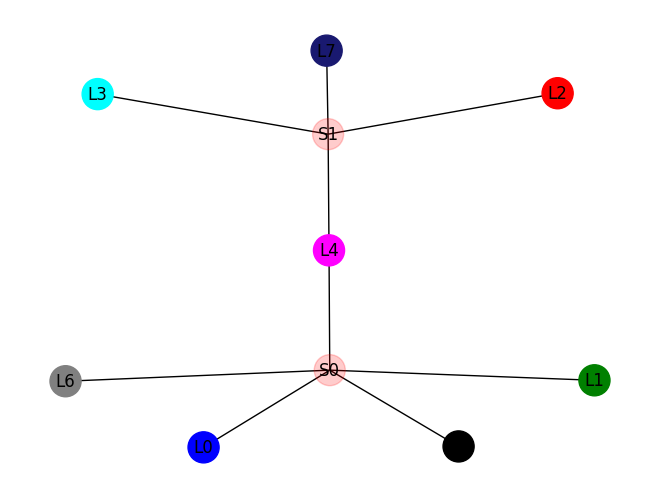

In [96]:
nviz.visualize_neuron_limbs(neuron_obj)

limb_name = L2

 Working on visualization type: mesh

 Working on visualization type: skeleton


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

No limb name was given so using L2 because was the limb in the first key


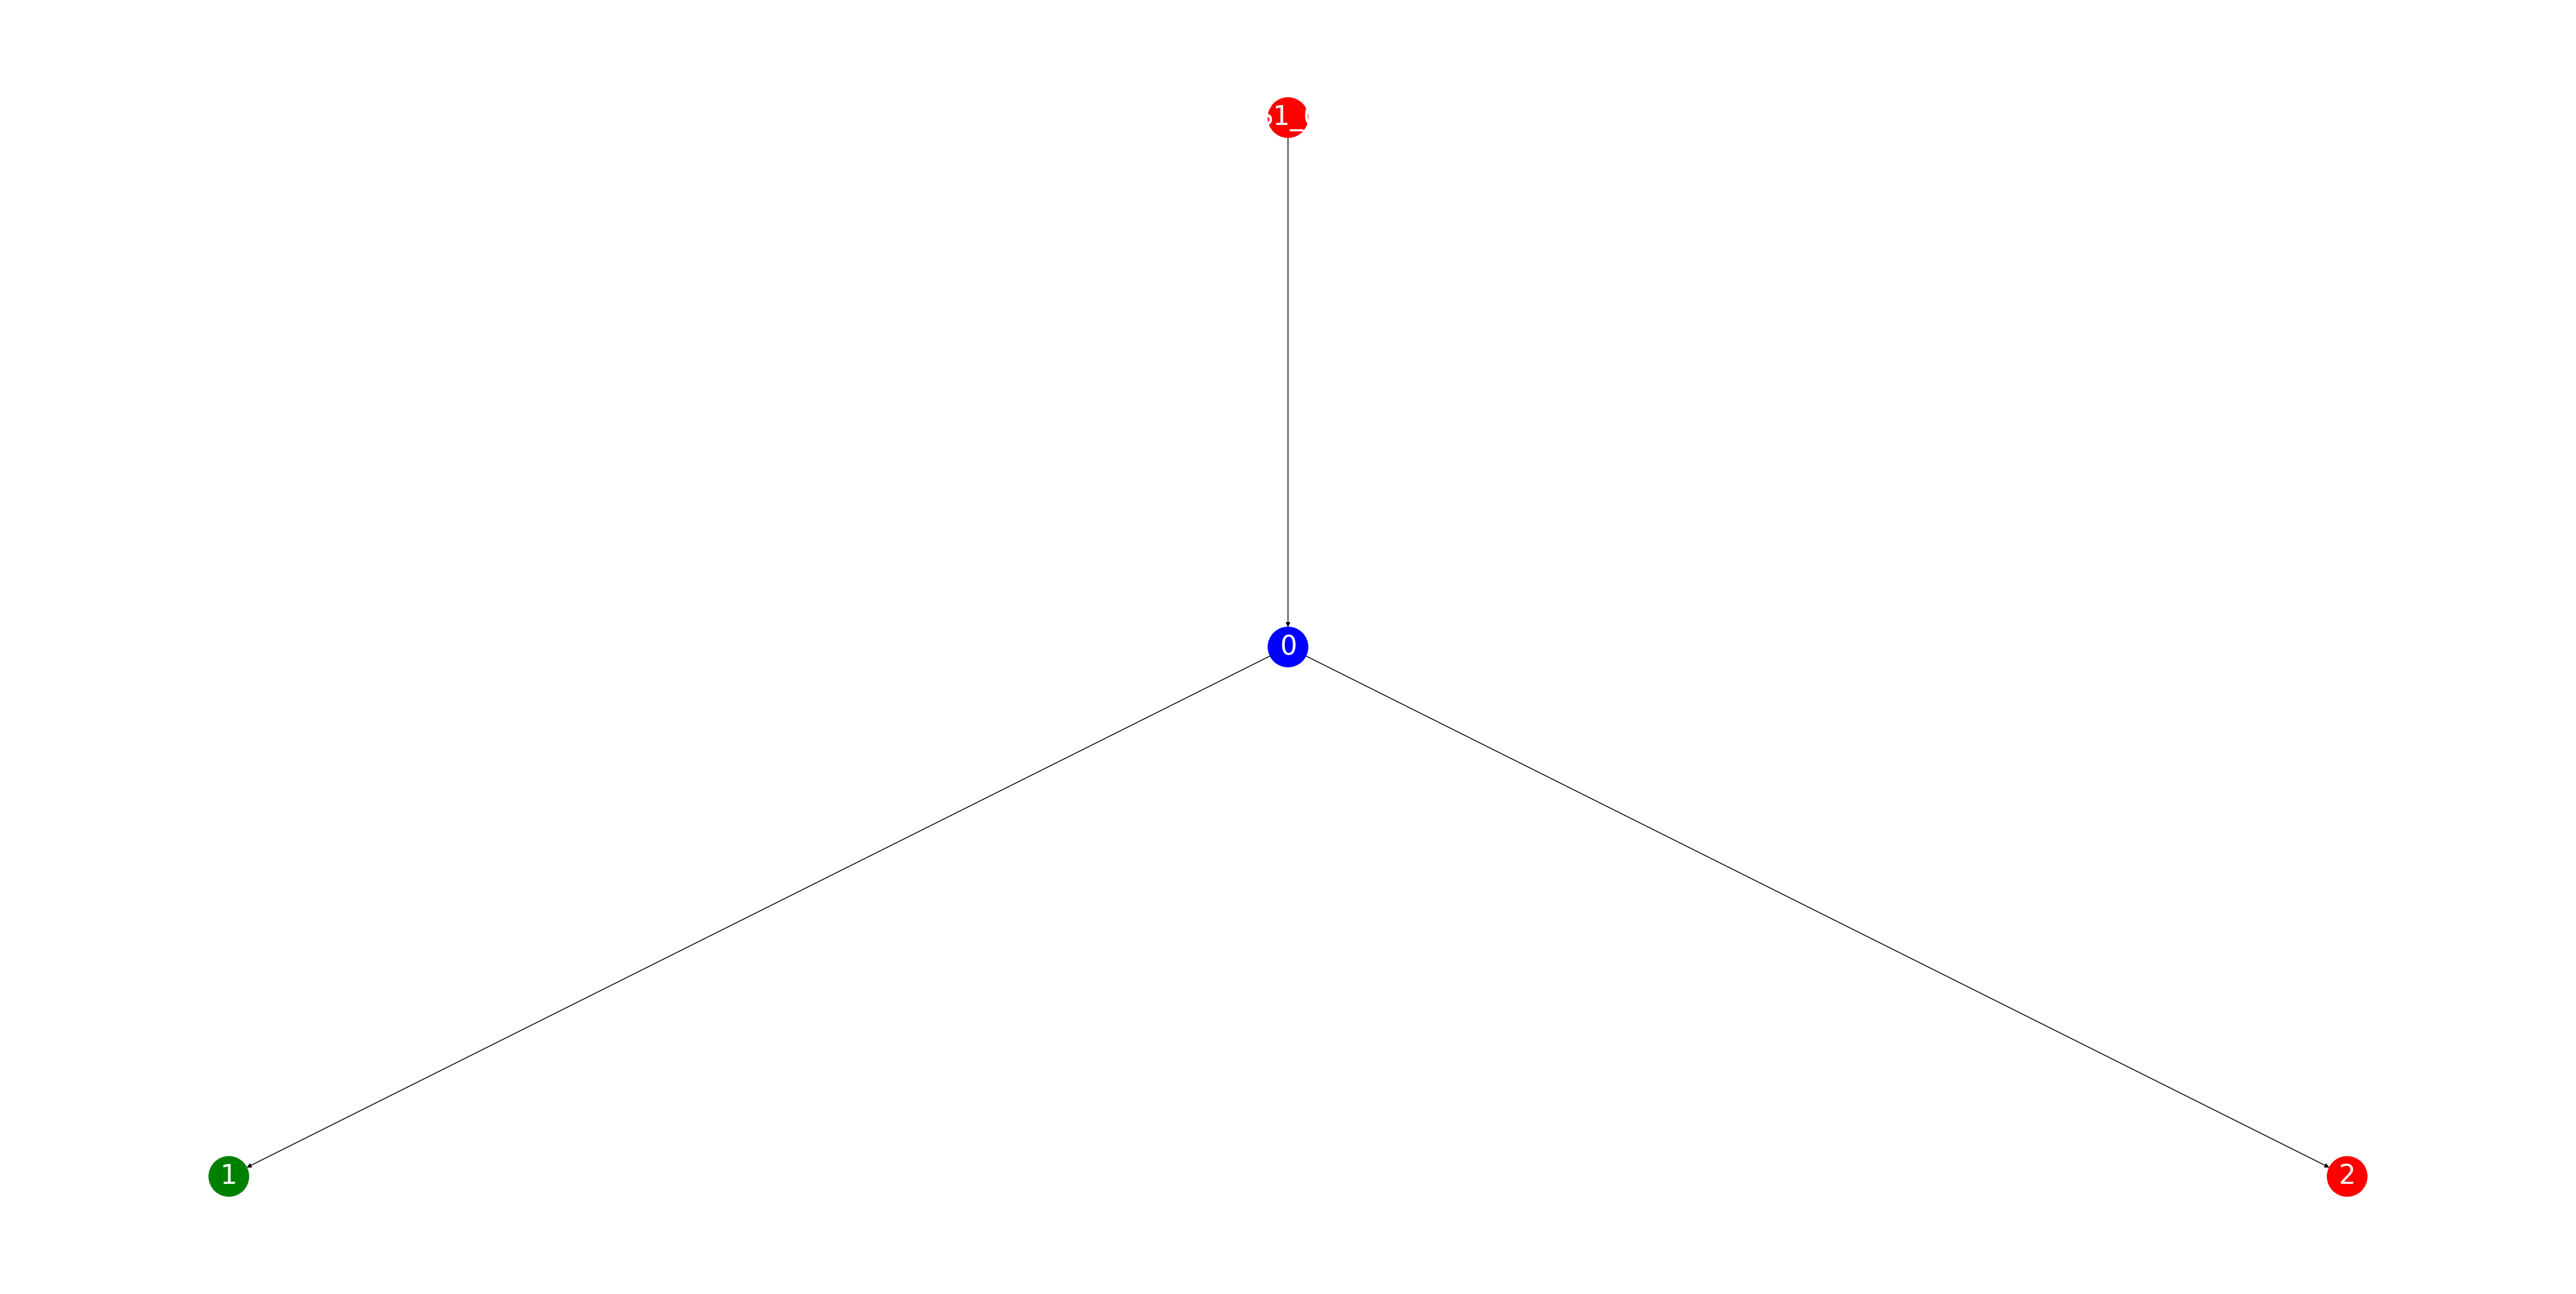

In [97]:
nviz.visualize_neuron_specific_limb(neuron_obj,"L2")

In [100]:
ipvu.plot_objects(neuron_obj[2][0].mesh)

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

# Calculate statistics

In [25]:
_ = neuron_obj.calculate_decomposition_products(
    store_in_obj = True,
)

In [26]:
print(neuron_obj.pipeline_products)

{
  'decimation':
  {
    'decimation_parameters':
    {
      'decimation_ratio':0.25,
    },
    'segment_id':864691135510518224,
  },
  'soma_identification':
  {
    'glia_meshes':[],
    'nuclei_meshes':[<trimesh.Trimesh(vertices.shape=(6494, 3), faces.shape=(15575, 3))>, <trimesh.Trimesh(vertices.shape=(3256, 3), faces.shape=(5810, 3))>, <trimesh.Trimesh(vertices.shape=(2064, 3), faces.shape=(4789, 3))>, <trimesh.Trimesh(vertices.shape=(2022, 3), faces.shape=(4628, 3))>, <trimesh.Trimesh(vertices.shape=(1922, 3), faces.shape=(4396, 3))>, <trimesh.Trimesh(vertices.shape=(1089, 3), faces.shape=(2556, 3))>, <trimesh.Trimesh(vertices.shape=(864, 3), faces.shape=(1989, 3))>, <trimesh.Trimesh(vertices.shape=(723, 3), faces.shape=(1611, 3))>, <trimesh.Trimesh(vertices.shape=(693, 3), faces.shape=(1561, 3))>, <trimesh.Trimesh(vertices.shape=(612, 3), faces.shape=(1378, 3))>, <trimesh.Trimesh(vertices.shape=(456, 3), faces.shape=(742, 3))>, <trimesh.Trimesh(vertices.shape=(344, 3), faces.

# Saving off neuron

In [27]:
vdi.save_neuron_obj(
    neuron_obj,
    verbose = True
)

Total time for soma meshes compression = 0.26013970375061035
Total time for insignificant_limbs,inside_pieces,non_soma_touching_meshes,not_processed_soma_containing_meshes compression = 1.0219955444335938
Total time for limb_meshes compression = 0.9331722259521484
    Starting Limb Correspondence Compression


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Total time for new_limb_correspondence compression = 5.960491418838501
Cleared mesh: <trimesh.Trimesh(vertices.shape=(6494, 3), faces.shape=(15575, 3))>:140215638046752
Cleared mesh: <trimesh.Trimesh(vertices.shape=(3256, 3), faces.shape=(5810, 3))>:140215638074224
Cleared mesh: <trimesh.Trimesh(vertices.shape=(2064, 3), faces.shape=(4789, 3))>:140215638077056
Cleared mesh: <trimesh.Trimesh(vertices.shape=(2022, 3), faces.shape=(4628, 3))>:140215637965264
Cleared mesh: <trimesh.Trimesh(vertices.shape=(1922, 3), faces.shape=(4396, 3))>:140215637966224
Cleared mesh: <trimesh.Trimesh(vertices.shape=(1089, 3), faces.shape=(2556, 3))>:140215638075712
Cleared mesh: <trimesh.Trimesh(vertices.shape=(864, 3), faces.shape=(1989, 3))>:140215638047520
Cleared mesh: <trimesh.Trimesh(vertices.shape=(723, 3), faces.shape=(1611, 3))>:140215128618944
Cleared mesh: <trimesh.Trimesh(vertices.shape=(693, 3), faces.shape=(1561, 3))>:140215128640528
Cleared mesh: <trimesh.Trimesh(vertices.shape=(612, 3), fa

'864691135510518224.pbz2'

# Reloading the Neuron

In [28]:
neuron_obj_rec = vdi.load_neuron_obj(
    segment_id = segment_id,
    #mesh_decimated = mesh_decimated
)

Decompressing Neuron in minimal output mode...please wait


In [29]:
print(neuron_obj_rec.pipeline_products)

{
  'decimation':
  {
    'decimation_parameters':
    {
      'decimation_ratio':0.25,
    },
    'segment_id':864691135510518224,
  },
  'soma_identification':
  {
    'glia_meshes':[],
    'nuclei_meshes':[<trimesh.Trimesh(vertices.shape=(6494, 3), faces.shape=(15575, 3))>, <trimesh.Trimesh(vertices.shape=(3256, 3), faces.shape=(5810, 3))>, <trimesh.Trimesh(vertices.shape=(2064, 3), faces.shape=(4789, 3))>, <trimesh.Trimesh(vertices.shape=(2022, 3), faces.shape=(4628, 3))>, <trimesh.Trimesh(vertices.shape=(1922, 3), faces.shape=(4396, 3))>, <trimesh.Trimesh(vertices.shape=(1089, 3), faces.shape=(2556, 3))>, <trimesh.Trimesh(vertices.shape=(864, 3), faces.shape=(1989, 3))>, <trimesh.Trimesh(vertices.shape=(723, 3), faces.shape=(1611, 3))>, <trimesh.Trimesh(vertices.shape=(693, 3), faces.shape=(1561, 3))>, <trimesh.Trimesh(vertices.shape=(612, 3), faces.shape=(1378, 3))>, <trimesh.Trimesh(vertices.shape=(456, 3), faces.shape=(742, 3))>, <trimesh.Trimesh(vertices.shape=(344, 3), faces.

# Step 4A: Multi Soma Split Suggestions

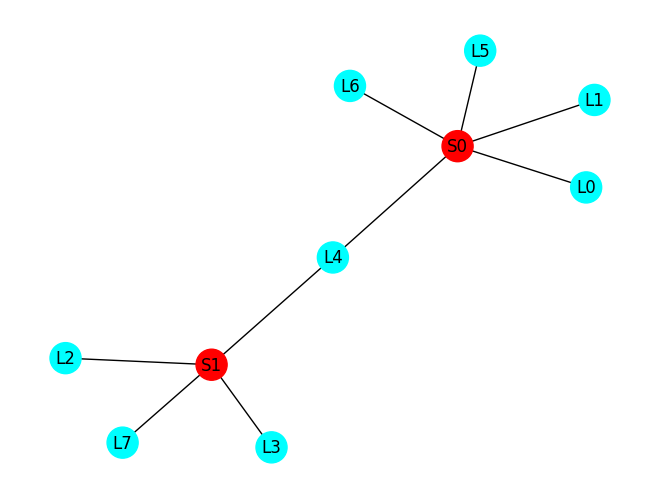

In [30]:
from neurd import neuron_visualizations as nviz
nviz.plot_soma_limb_concept_network(
    neuron_obj
)

In [31]:
multi_soma_split_parameters = dict()

In [104]:
_ = neuron_obj.calculate_multi_soma_split_suggestions(
    plot = True,
    store_in_obj = True,
    **multi_soma_split_parameters
)


n_paths_multi_soma = 1
n_paths_multi_touch = 0
n_paths_cut = 1


-------- Suggestions for Limb 4------


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [105]:
neuron_obj.pipeline_products.multi_soma_split_suggestions.multi_soma_split_parameters = multi_soma_split_parameters

    multi_soma_split_parameters:{}
    n_paths_cut:1
    red_blue_split_results:{4: [{'S0_0': {0: [{'error_branches': array([1., 2., 4., 5., 6.]), 'error_branches_skeleton_length': 71314.8681393928, 'valid_branches': array([0]), 'parent_branch': 0, 'parent_branch_width': 428.40439724621825, 'parent_branch_axon': False, 'n_error_branches': 5, 'valid_points': array([[1491700.66666667,  587848.86666667, 1110594.33333333],
       [1489989.33333333,  587939.06666667, 1113021.66666667]]), 'error_points': array([[1493550.        ,  586432.9       , 1108461.        ],
       [1492642.        ,  586538.9       , 1107802.66666667],
       [1492624.        ,  587993.        , 1106840.        ],
       [1494101.66666667,  586228.96666667, 1111083.        ],
       [1493232.        ,  585881.86666667, 1112968.        ],
       [1491639.66666667,  585431.63333333, 1114106.66666667],
       [1495465.33333333,  587016.3       , 1109645.66666667],
       [1496905.        ,  586996.53333333, 1109881.333

# Step 4B: Multi Soma Split Execution

In [108]:
neuron_list = neuron_obj.multi_soma_split_execution(
    verbose = False,
)

In [110]:
ipvu.plot_objects(
    meshes = [
        neuron_list[0].mesh_from_branches,
        neuron_list[1].mesh_from_branches,
    ],
    meshes_colors=["red","blue"]
)

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [35]:
n1 = neuron_list[0]
print(n1.pipeline_products)

{
  'decimation':
  {
    'decimation_parameters':
    {
      'decimation_ratio':0.25,
    },
    'segment_id':864691135510518224,
  },
  'soma_identification':
  {
    'glia_meshes':[],
    'nuclei_meshes':[<trimesh.Trimesh(vertices.shape=(6494, 3), faces.shape=(15575, 3))>, <trimesh.Trimesh(vertices.shape=(3256, 3), faces.shape=(5810, 3))>, <trimesh.Trimesh(vertices.shape=(2064, 3), faces.shape=(4789, 3))>, <trimesh.Trimesh(vertices.shape=(2022, 3), faces.shape=(4628, 3))>, <trimesh.Trimesh(vertices.shape=(1922, 3), faces.shape=(4396, 3))>, <trimesh.Trimesh(vertices.shape=(1089, 3), faces.shape=(2556, 3))>, <trimesh.Trimesh(vertices.shape=(864, 3), faces.shape=(1989, 3))>, <trimesh.Trimesh(vertices.shape=(723, 3), faces.shape=(1611, 3))>, <trimesh.Trimesh(vertices.shape=(693, 3), faces.shape=(1561, 3))>, <trimesh.Trimesh(vertices.shape=(612, 3), faces.shape=(1378, 3))>, <trimesh.Trimesh(vertices.shape=(456, 3), faces.shape=(742, 3))>, <trimesh.Trimesh(vertices.shape=(344, 3), faces.

# Step 5: Cell Typing

In [36]:
from neurd import neuron_pipeline_utils as npu

In [111]:
n1 = neuron_list[0]

In [62]:
neuron_obj_axon = npu.cell_type_ax_dendr_stage(
    n1,
    mesh_decimated = mesh_decimated,
    plot_axon = False,
)


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 4


Number of segments: 3


Number of segments: 3


Number of segments: 3


Number of segments: 1


Number of segments: 4


Number of segments: 4


Number of segments: 3


Number of segments: 2


Number of segments: 5


Number of segments: 1


Number of segments: 1


Number of segments: 1


Number of segments: 1


Number of segments: 2


Number of segments: 1


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 3


Number of segments: 3


Number of segments: 3


Number of segments: 1


Number of segments: 1


Number of segments: 1


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segme


Number of segments: 2


Number of segments: 4


Number of segments: 4


Number of segments: 1


Number of segments: 1


Number of segments: 1


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 1


Number of segments: 3


Number of segments: 3


Number of segments: 3


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 3


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 3


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 1


Number of segments: 3


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segme

Number of segments: 2


Number of segments: 1


Number of segments: 1


Number of segments: 1


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 3


Number of segments: 3


Number of segments: 3


Number of segments: 1


Number of segments: 1


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 1


Number of segments: 3


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 3


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segments: 2


Number of segmen

100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.6641898155212402
branches_touching_root = [13]
combining close nodes
combine_threshold = 1300
length of Graph = 7906
After combining close endpoints max(kept_branches_idx) = 85, len(kept_branches_idx) = 75
empty_indices % = 0.0
 conflict_indices % = 0.028463139120095123
Decomposing first pass: 6.6084864139556885
Only Using MeshParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 1.0728836059570312e-05
Total time for MAP sublimb processing 3.0994415283203125e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 1.52587890625e-05
Fixing Possible Soma Extension Branch for Sublimb 0
Total time for mesh KDTree = 0.02882552146911621
sbv[0].reshape(-1,3) = [[1484150.   588282.7 1095391. ]]
closest_sk_pt_coord BEFORE = [1484209.07018222  588125.41800575 1095073.94391184]
curren

100%|██████████| 1/1 [00:00<00:00, 372.76it/s]

meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.017223358154296875
branches_touching_root = [0]
combining close nodes
combine_threshold = 1300
length of Graph = 20
After combining close endpoints max(kept_branches_idx) = 0, len(kept_branches_idx) = 1
empty_indices % = 0.0
 conflict_indices % = 0.0
Decomposing first pass: 0.020273923873901367
Only Using MeshParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 1.0967254638671875e-05
Total time for MAP sublimb processing 2.86102294921875e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 2.4557113647460938e-05
Do Not Need to Fix MP Decomposition 0 so just continuing
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 0.0385289192199707
Removed 0 skeletal branches
175 176
For marked faces: None
empty_indices % = 0.0
 

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

--> time = 0.11010599136352539
Floating 1: <trimesh.Trimesh(vertices.shape=(3012, 3), faces.shape=(5404, 3))>
invalidation_d = 1500
use_adaptive_invalidation_d= False
axon_width_preprocess_limb_max = 200
filter_end_node_length= 1150
filter_end_node_length_meshparty = 1150
invalidation_d = 1500
root_curr = None
Time for preparing soma vertices and root: 5.0067901611328125e-06
invalidation_d = 1500
smooth_neighborhood = 0
cc_vertex_thresh = 10


100%|██████████| 1/1 [00:00<00:00, 19.40it/s]


meshparty_segment_size = 100
Time for 1st pass MP skeletonization: 0.09237098693847656
branches_touching_root = [6]
combining close nodes
combine_threshold = 1300
length of Graph = 344
After combining close endpoints max(kept_branches_idx) = 12, len(kept_branches_idx) = 11
empty_indices % = 0.0
 conflict_indices % = 0.0902269743012568
Decomposing first pass: 0.3002033233642578
Only Using MeshParty Skeletonization and Mesh Correspondence
Another print
Divinding into MP and MAP pieces: 7.867813110351562e-06
Total time for MAP sublimb processing 3.337860107421875e-06
---- Working on MP Decomposition #0 ----
Using Quicker soma_to_piece_touching_vertices because no MAP and only one sublimb_mesh piece 
MP filtering soma verts: 1.4781951904296875e-05
Do Not Need to Fix MP Decomposition 0 so just continuing
There were not both MAP and MP pieces so skipping the stitch resolving phase
Time for decomp of Limb = 0.4043552875518799
Removed 2 skeletal branches
5403 5404
For marked faces: None
empty_

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

--> time = 0.9365460872650146
The closest float distance was 23581.571737481798 which was greater than the maximum stitch distance 5000
 --> so ending the floating mesh stitch processs
concept_network_dict = {0: [<python_tools.networkx_utils.GraphOrderedEdges object at 0x7f84d128adc0>]}


----Working on seperate_graph 0----


---------Working on soma_idx = 0, soma_group_idx 0, endpt = [1484351.   588129.9 1095200. ]---------
Starting_edge inside branches_to_conept = [[1467806.   619005.5 1081192. ]
 [1484351.   588129.9 1095200. ]]
At the start, starting_node (in terms of the skeleton, that shouldn't match the starting edge) = [59]
printing out current edge:
[[1484351.   588129.9 1095200. ]
 [1467806.   619005.5 1081192. ]]
edge_endpoints_to_process was empty so exiting loop after 76 iterations
starting_node in concept map (that should match the starting edge) = 53
Total time for branches to concept conversion = 0.6820981502532959

Done generating concept network 



Number of segments

In [63]:
# syn_dict = vdi.segment_id_to_synapse_dict(segment_id)
# nviz.plot_objects(
#     neuron_obj.mesh,
#     scatters=[syn_dict["presyn"]["synapse_coordinates"]]
# )

In [112]:
nviz.plot_axon(
    neuron_obj_axon
)


 Working on visualization type: mesh

 Working on visualization type: skeleton


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [115]:
print(neuron_obj_axon.pipeline_products.cell_type_ax_dendr)

    axon_angle_max:144.06
    axon_angle_min:144.06
    axon_area:554.6607853653893
    axon_bbox_volume:0.837546263833745
    axon_bbox_x_max:1525626.0
    axon_bbox_x_max_soma_relative:36745.23941682768
    axon_bbox_x_min:1430163.0
    axon_bbox_x_min_soma_relative:-58717.76058317232
    axon_bbox_y_max:660063.0
    axon_bbox_y_max_soma_relative:70762.90626207273
    axon_bbox_y_min:559332.6
    axon_bbox_y_min_soma_relative:-29967.49373792729
    axon_bbox_z_max:1114281.0
    axon_bbox_z_max_soma_relative:13628.686544879572
    axon_bbox_z_min:1027182.0
    axon_bbox_z_min_soma_relative:-73470.31345512043
    axon_branch_length_mean:10.453985490894182
    axon_branch_length_median:5.066221657520934
    axon_length:784.0489118170636
    axon_n_branches:75
    axon_n_limbs:5
    axon_n_long_branches:1
    axon_n_medium_branches:31
    axon_n_short_branches:43
    axon_skeletal_length:784048.9118170637
    axon_skeleton:[[[1430163.          633318.         1114281.        ]
  [1430219

# Autoproofreading Stage

About to do syn_density stats
syn_density_post = 0.8809753476133828
syn_density_head = 0.3682765797400207
syn_density_neck = 0.005415832055000304
syn_density_shaft = 0.4007715720700225
sk_length_synapse_density = 553931.5048054664
About to do spine_density stats
postsyn_limb_branch = {'L0': array([0, 1, 3, 4, 5, 9]), 'L2': array([3]), 'L3': array([0]), 'L4': array([0])}
sk_length = 524541.5546859367
# of spines = 256
Density = 0.4880452229438278
spine_density = 0.4880452229438278 (multiplier = 1000)
sk_length spine density = 524541.5546859367
Done stats
Not apply_hand_made_low_rules
For model: LogisticRegression(class_weight={'excitatory': 1, 'inhibitory': 1.5}) 
with features: ['syn_density_shaft', 'spine_density']
pred_class = excitatory, pred_class_label = excitatory
Total time for e/i calculations = 0.07892346382141113
baylor_e_i = excitatory

*****Using v7 Filters!!!


Current node skip distance was 1499.2469745780515 but max skip distance was 1499.2469745780515
Current node skip 

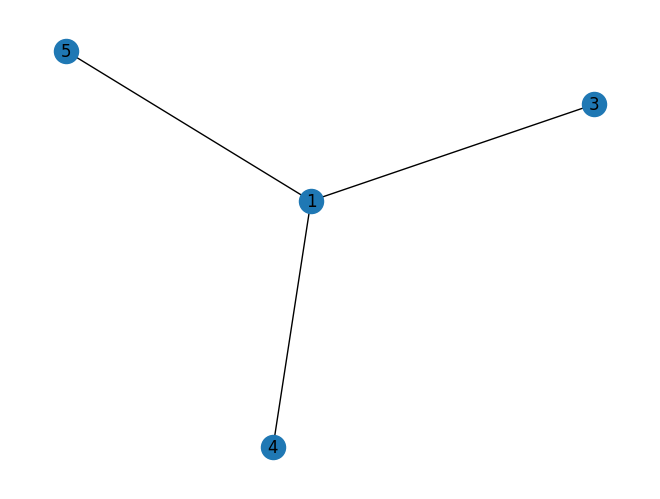

Performing global features query
Done with edge_df: 0.0007987022399902344
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
   u  v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  1  3     18.23    7.006226               0.095976              0.000009   
1  1  4     51.52   26.989558               0.369721              0.000194   
2  1  5     38.18   27.008424               0.270062              0.000038   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  
0                0                       None                          None  
1                2                       None                          None  
2                1                       None                          None  
Afer Global query: 
   u  v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  1  3     18.23    7.006226               0.095976              0.000009   


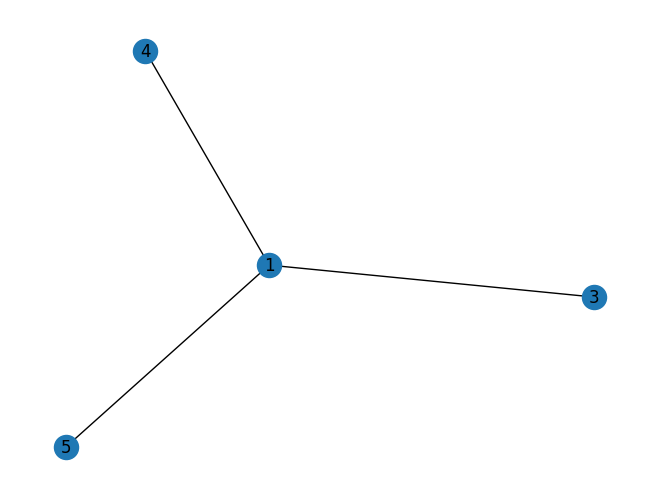

Performing node features query
Done with edge_df: 0.0010242462158203125
Performing Edge Query
After edge filter, # of rows = 1
Exporting the edges
Deleteing edges only

--- Before Node Query ---
   u  v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  1  3     18.23    7.006226               0.095976              0.000009   
1  1  4     51.52   26.989558               0.369721              0.000194   
2  1  5     38.18   27.008424               0.270062              0.000038   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  \
0                0                       None                          None   
1                2                       None                          None   
2                1                       None                          None   

  above_threshold_delete  
0                   None  
1                   True  
2                   None  
Afer Node query: 
   u  v  sk_angle  width_diff  width_diff_percent

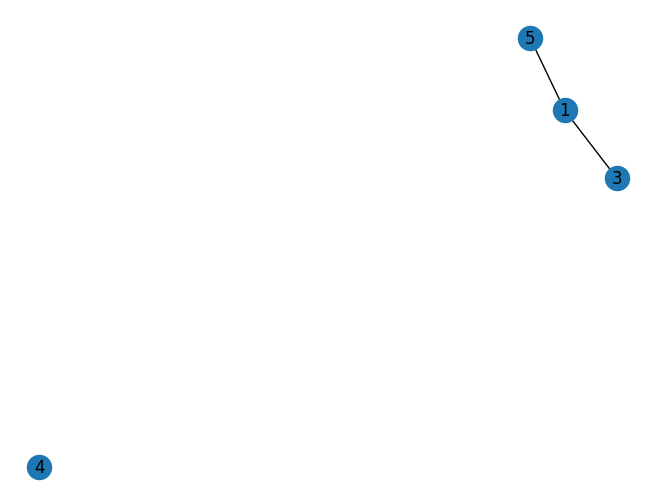

for upstream node 5, winning_node = None, error_branches = [1 3 4]
Inside high_degree_false_positive_low_sibling_filter ****
No winning branch so returning
Current node skip distance was 1439.6098165500885 but max skip distance was 1439.6098165500885
Current node skip distance was 1419.800859346442 but max skip distance was 1419.800859346442
Current node skip distance was 1395.1715386565604 but max skip distance was 1395.1715386565604
Current node skip distance was 1728.6974107197009 but max skip distance was 1728.6974107197009
Current node skip distance was 1470.6737540170857 but max skip distance was 1470.6737540170857
Current node skip distance was 1419.1567072051882 but max skip distance was 1935.3558329998682
Current node skip distance was 1408.3718172215047 but max skip distance was 1408.3718172215047
Current node skip distance was 1423.6329164741965 but max skip distance was 1423.6329164741965
Current node skip distance was 1557.7689972408803 but max skip distance was 1660.76298

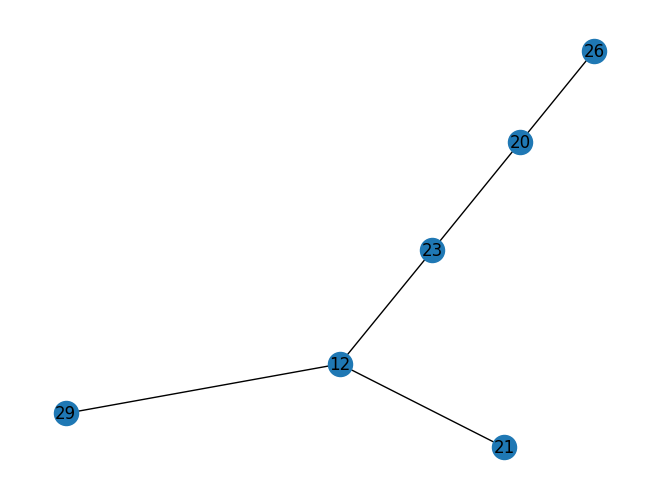

Performing global features query
Done with edge_df: 0.001138448715209961
Performing Edge Query
After edge filter, # of rows = 1
Exporting the edges
Deleteing edges only

--- Before Global Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  12  21     52.72   29.595414               0.488392                   0.0   
1  12  23     57.20    1.161105               0.019161                   0.0   
2  12  29     34.74   10.451040               0.172466                   0.0   
3  23  20     53.63   31.621571               0.338632                   0.0   
4  26  20     14.73   13.415842               0.143669                   0.0   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  
0                0                       None                          None  
1                0                       None                          None  
2                0                       None                          None  
3        

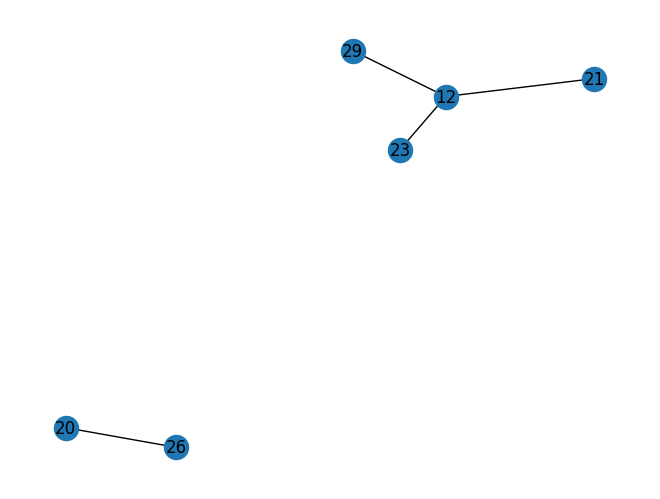

Performing node features query
Done with edge_df: 0.0009026527404785156
Performing Edge Query
After edge filter, # of rows = 2
Exporting the edges
Deleteing edges only

--- Before Node Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  12  21     52.72   29.595414               0.488392                   0.0   
1  12  23     57.20    1.161105               0.019161                   0.0   
2  12  29     34.74   10.451040               0.172466                   0.0   
3  26  20     14.73   13.415842               0.143669                   0.0   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  \
0                0                       None                          None   
1                0                       None                          None   
2                0                       None                          None   
3                0                      False                          None   

  above_

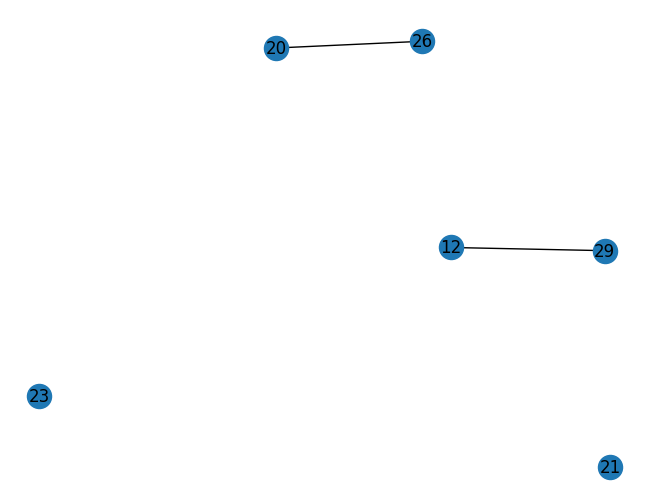

for upstream node 20, winning_node = 26, error_branches = [12 21 23 29]
Inside high_degree_false_positive_low_sibling_filter ****
Not exactly 2 downstream errors so returning
Current node skip distance was 1542.4709318505866 but max skip distance was 1542.4709318505866
Current node skip distance was 1500.9798101341728 but max skip distance was 1500.9798101341728
Current node skip distance was 1423.9946428663225 but max skip distance was 1423.9946428663225
Current node skip distance was 1844.1910151040552 but max skip distance was 1850.758665631278
Current node skip distance was 1850.758665631278 but max skip distance was 1850.758665631278
Current node skip distance was 1611.6505289229938 but max skip distance was 1611.6505289229938
Current node skip distance was 1551.6937888199488 but max skip distance was 1551.6937888199488
Current node skip distance was 1755.205742183186 but max skip distance was 1844.1910151040552
branch_match_query = :
(((width_diff < 75) or (width_diff_percentage 

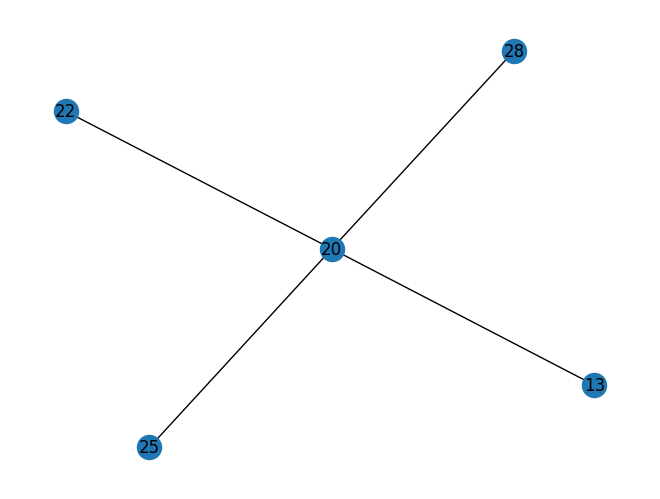

Performing global features query
Done with edge_df: 0.0008509159088134766
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  13  20     20.72   35.371049               0.609749                   0.0   
1  20  22     27.54   13.145131               0.140770                   0.0   
2  20  25     63.33   70.801794               0.758209                   0.0   
3  20  28     13.50   47.869093               0.338898                   0.0   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  
0                0                       None                          None  
1                0                       None                          None  
2                0                       None                          None  
3                0                       None                          None  
Afer Globa

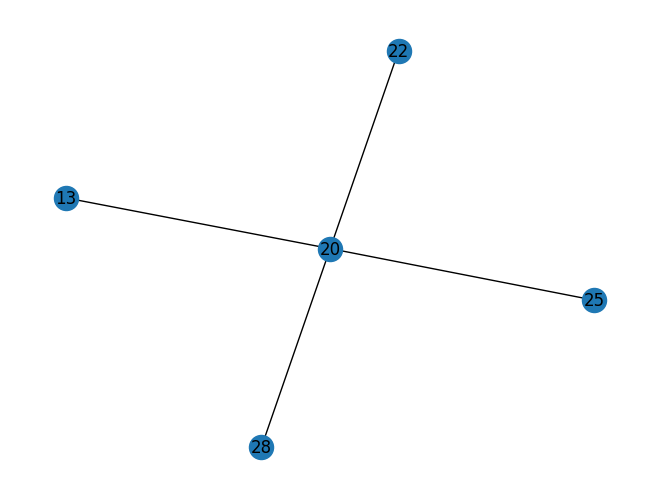

Performing node features query
Done with edge_df: 0.0008366107940673828
Performing Edge Query
After edge filter, # of rows = 1
Exporting the edges
Deleteing edges only

--- Before Node Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  13  20     20.72   35.371049               0.609749                   0.0   
1  20  22     27.54   13.145131               0.140770                   0.0   
2  20  25     63.33   70.801794               0.758209                   0.0   
3  20  28     13.50   47.869093               0.338898                   0.0   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  \
0                0                       None                          None   
1                0                       None                          None   
2                0                       None                          None   
3                0                       None                          None   

  above_

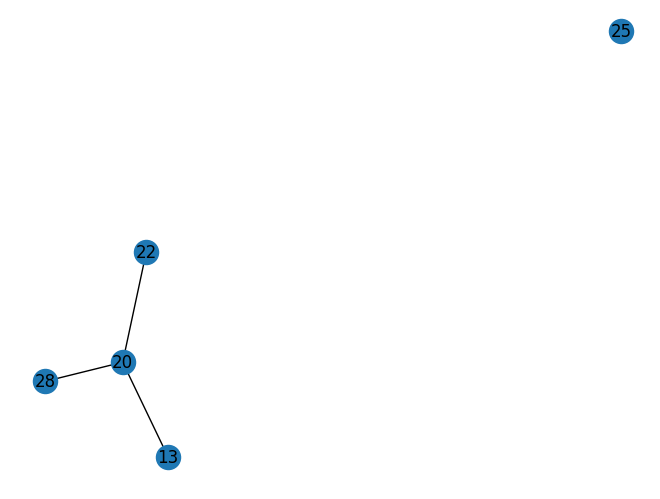

for upstream node 28, winning_node = None, error_branches = [13 20 22 25]
Inside high_degree_false_positive_low_sibling_filter ****
No winning branch so returning
Current node skip distance was 1462.702705562729 but max skip distance was 1462.702705562729
Current node skip distance was 1820.0150826095676 but max skip distance was 1820.0150826095676
branch_match_query = :
(((width_diff < 75) or (width_diff_percentage < 0.6)) and (sk_angle < 65))and ((synapse_density_diff<0.00015) or (n_synapses_diff < 6))
Done with edge_df: 0.0010156631469726562
Performing Edge Query
After edge filter, # of rows = 3
Exporting the edges
Deleteing edges only

--- Before Local Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  10  16     20.86   41.022819               0.304126              0.000082   
1  10  28     47.78    6.362000               0.047165              0.000000   
2  10  30     91.23   21.916241               0.139769              0.000000   
3  16

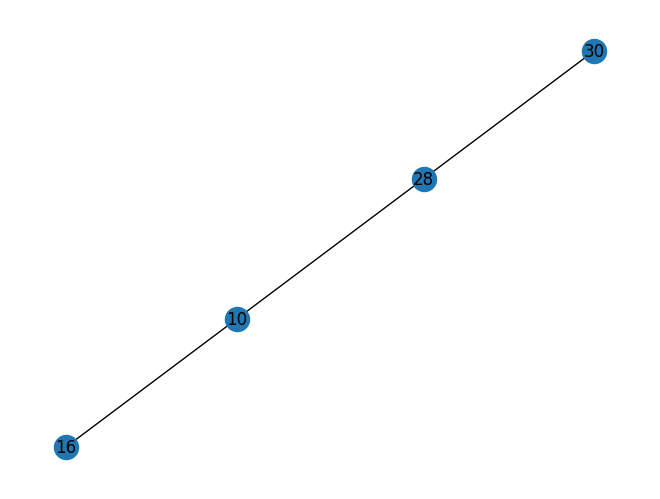

Performing global features query
Done with edge_df: 0.0009834766387939453
Performing Edge Query
After edge filter, # of rows = 1
Exporting the edges
Deleteing edges only

--- Before Global Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  10  16     20.86   41.022819               0.304126              0.000082   
1  10  28     47.78    6.362000               0.047165              0.000000   
2  28  30     43.46   15.554242               0.099196              0.000000   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  
0                9                      False                          None  
1                0                       True                          None  
2                0                       None                          None  
Afer Global query: 
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  10  16     20.86   41.022819               0.304126              

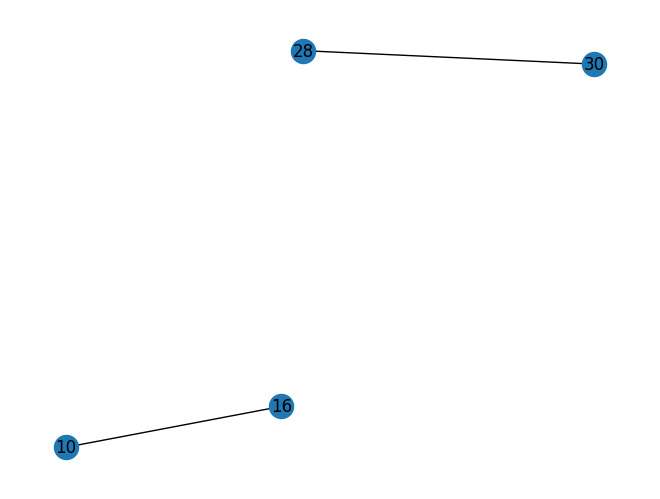

Performing node features query
Done with edge_df: 0.0014028549194335938
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Node Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  10  16     20.86   41.022819               0.304126              0.000082   
1  28  30     43.46   15.554242               0.099196              0.000000   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  \
0                9                      False                          None   
1                0                       None                          None   

  above_threshold_delete  
0                   None  
1                   None  
Afer Node query: 
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  10  16     20.86   41.022819               0.304126              0.000082   
1  28  30     43.46   15.554242               0.099196             

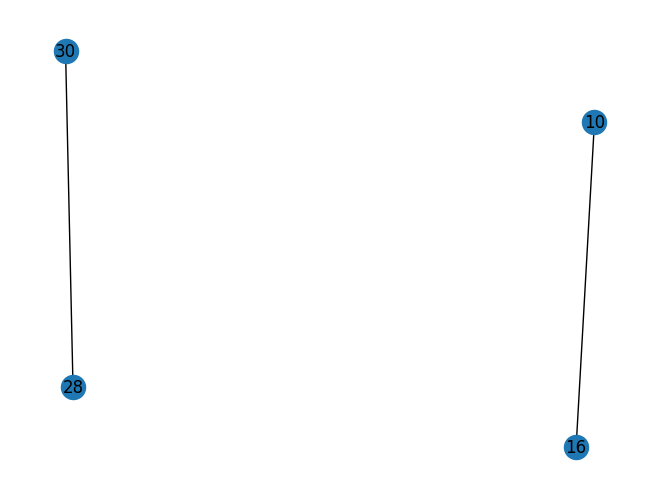

for upstream node 30, winning_node = 28, error_branches = [10 16]
Inside high_degree_false_positive_low_sibling_filter ****
Upstream width (141.24937812396485) less than width_min(250)
Current node skip distance was 1502.8179992499754 but max skip distance was 1502.8179992499754
Current node skip distance was 1468.8626307330655 but max skip distance was 1539.7949629700095
Current node skip distance was 1608.7992850545759 but max skip distance was 1820.0150826095676
branch_match_query = :
(((width_diff < 75) or (width_diff_percentage < 0.6)) and (sk_angle < 65))and ((synapse_density_diff<0.00015) or (n_synapses_diff < 6))
Done with edge_df: 0.0010180473327636719
Performing Edge Query
After edge filter, # of rows = 3
Exporting the edges
Deleteing edges only

--- Before Local Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  27  30     77.08   64.397111               0.696889                   0.0   
1  27  32     25.52   19.879478               

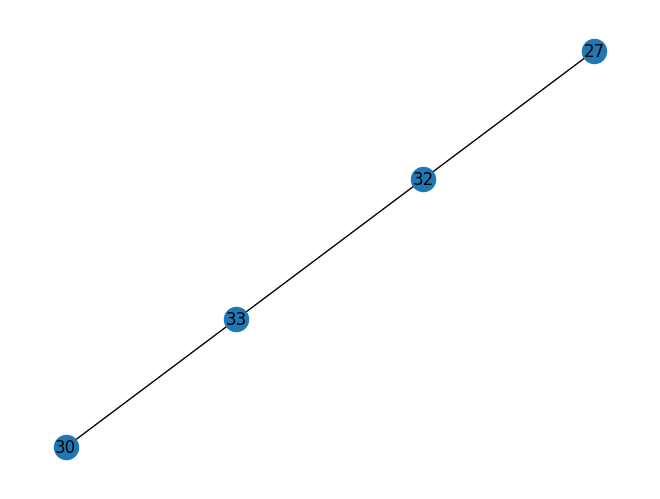

Performing global features query
Done with edge_df: 0.0008831024169921875
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  27  32     25.52   19.879478               0.215131                   0.0   
1  30  33     47.52   50.691791               0.477720                   0.0   
2  32  33     12.61   33.584797               0.316504                   0.0   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  
0                0                       None                          None  
1                0                       None                          None  
2                0                       None                          None  
Afer Global query: 
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  27  32     25.52   19.879478               0.215131              

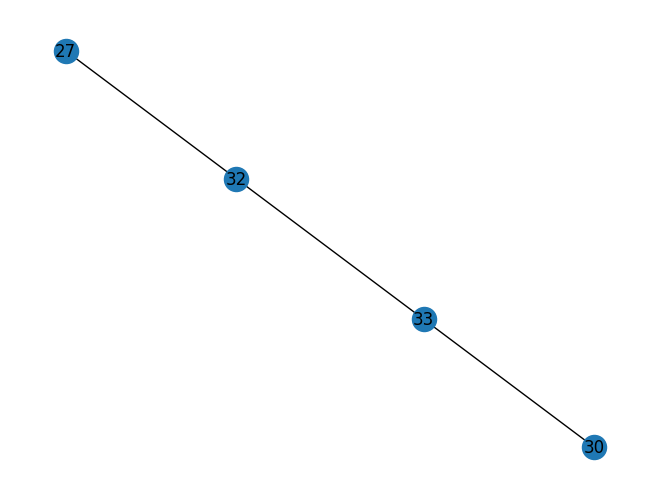

Performing node features query
Done with edge_df: 0.0008757114410400391
Performing Edge Query
After edge filter, # of rows = 1
Exporting the edges
Deleteing edges only

--- Before Node Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  27  32     25.52   19.879478               0.215131                   0.0   
1  30  33     47.52   50.691791               0.477720                   0.0   
2  32  33     12.61   33.584797               0.316504                   0.0   

   n_synapses_diff definite_partner_sk_delete definite_partner_width_delete  \
0                0                       None                          None   
1                0                       None                          None   
2                0                       None                          None   

  above_threshold_delete  
0                   None  
1                   True  
2                   None  
Afer Node query: 
    u   v  sk_angle  width_diff  width_di

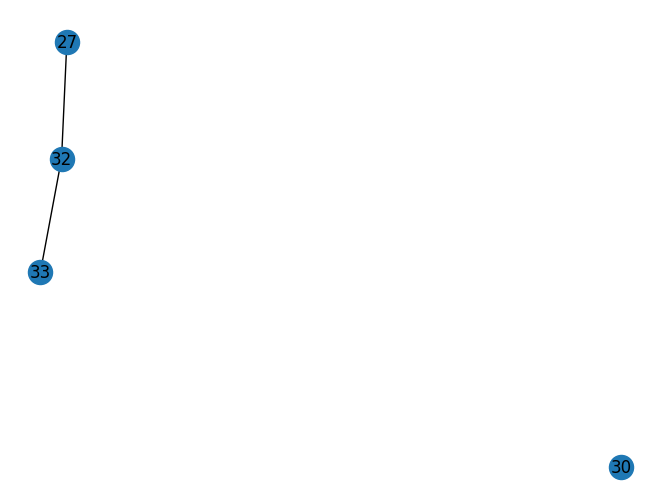

for upstream node 33, winning_node = None, error_branches = [27 30 32]
Inside high_degree_false_positive_low_sibling_filter ****
No winning branch so returning
Current node skip distance was 1744.7294638512403 but max skip distance was 1744.7294638512403
Current node skip distance was 1539.7949629700095 but max skip distance was 1539.7949629700095
Current node skip distance was 1445.6924835604466 but max skip distance was 1608.7992850545759
Current node skip distance was 1430.495890861237 but max skip distance was 1633.4055749248498
Current node skip distance was 1479.28828785825 but max skip distance was 1479.28828785825
Current node skip distance was 1438.787336903817 but max skip distance was 1438.787336903817
Current node skip distance was 1770.5097066954665 but max skip distance was 1770.5097066954665
Current node skip distance was 1459.4197789215646 but max skip distance was 2141.3451010899726
Current node skip distance was 1910.459116337433 but max skip distance was 1910.4591163

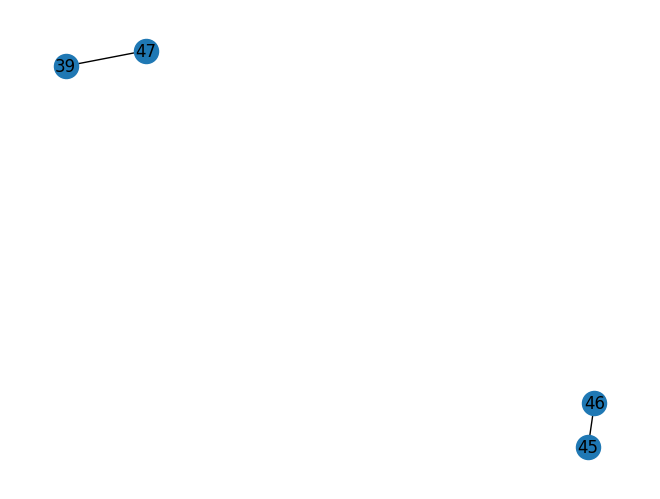

Performing global features query
Done with edge_df: 0.0009739398956298828
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Global Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  39  47     12.03    6.450551               0.085974                   0.0   
1  45  46     17.97   21.909888               0.109320                   0.0   

   n_synapses_diff  definite_partner_sk_delete  definite_partner_width_delete  
0                0                       False                          False  
1                0                       False                          False  
Afer Global query: 
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  39  47     12.03    6.450551               0.085974                   0.0   
1  45  46     17.97   21.909888               0.109320                   0.0   

   n_synapses_diff  definite_partner_sk_delete  definite_pa

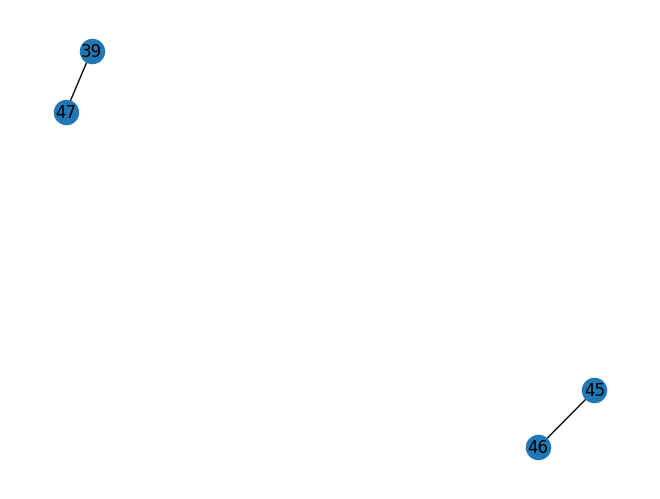

Performing node features query
Done with edge_df: 0.0017611980438232422
Performing Edge Query
After edge filter, # of rows = 0
Exporting the edges
Deleteing edges only

--- Before Node Query ---
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  39  47     12.03    6.450551               0.085974                   0.0   
1  45  46     17.97   21.909888               0.109320                   0.0   

   n_synapses_diff  definite_partner_sk_delete  definite_partner_width_delete  \
0                0                       False                          False   
1                0                       False                          False   

  above_threshold_delete  
0                   None  
1                   None  
Afer Node query: 
    u   v  sk_angle  width_diff  width_diff_percentage  synapse_density_diff  \
0  39  47     12.03    6.450551               0.085974                   0.0   
1  45  46     17.97   21.909888               0.109320       

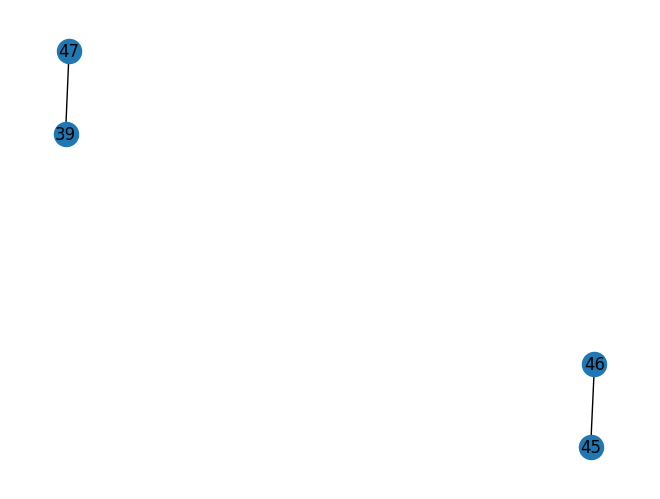

for upstream node 46, winning_node = 45, error_branches = [39 47]
Inside high_degree_false_positive_low_sibling_filter ****
Upstream width (178.5101879209841) less than width_min(250)
Current node skip distance was 1506.165582874341 but max skip distance was 1506.165582874341
Current node skip distance was 1450.4508458210582 but max skip distance was 1450.4508458210582
Current node skip distance was 2026.1613036853018 but max skip distance was 2026.1613036853018
Current node skip distance was 1874.4952927129884 but max skip distance was 2026.1613036853018
Current node skip distance was 1915.3718706738891 but max skip distance was 2299.759431541972
Current node skip distance was 1440.1882868033294 but max skip distance was 1468.5371695391739
Current node skip distance was 1494.8142487134844 but max skip distance was 1494.8142487134844
Current node skip distance was 1393.7589706183728 but max skip distance was 1393.7589706183728
Current node skip distance was 1468.5371695391739 but max s

In [67]:
neuron_obj_proof = npu.auto_proof_stage(
    neuron_obj_axon,
    mesh_decimated = mesh_decimated,
    calculate_after_proof_stats = False,
)

In [68]:
_ = npu.after_auto_proof_stats(
    neuron_obj_proof,
    store_in_obj = True,
)

No skeletons to stack so returning empty list

Working on compartment basal---
Compartment limb stats = {'n_limbs': 4, 'soma_angle_max': 171.08, 'soma_angle_min': 20.41}

Working on compartment apical_total---
Compartment limb stats = {'n_limbs': 0, 'soma_angle_max': None, 'soma_angle_min': None}

Working on compartment axon---
Compartment limb stats = {'n_limbs': 1, 'soma_angle_max': 80.63, 'soma_angle_min': 80.63}

Working on compartment dendrite---
Compartment limb stats = {'n_limbs': 4, 'soma_angle_max': 171.08, 'soma_angle_min': 20.41}


In [117]:
print(neuron_obj_proof.pipeline_products.auto_proof)

    apical_bbox_volume:0
    apical_bbox_x_max:0
    apical_bbox_x_max_soma_relative:0
    apical_bbox_x_min:0
    apical_bbox_x_min_soma_relative:0
    apical_bbox_y_max:0
    apical_bbox_y_max_soma_relative:0
    apical_bbox_y_min:0
    apical_bbox_y_min_soma_relative:0
    apical_bbox_z_max:0
    apical_bbox_z_max_soma_relative:0
    apical_bbox_z_min:0
    apical_bbox_z_min_soma_relative:0
    apical_branch_length_mean:0
    apical_branch_length_median:0
    apical_n_limbs:0
    apical_n_long_branches:0
    apical_n_medium_branches:0
    apical_n_short_branches:0
    apical_soma_angle_max:None
    apical_soma_angle_min:None
    axon_area:100.79956488606535
    axon_bbox_volume:0.020887414933042067
    axon_bbox_x_max:1484351.0
    axon_bbox_x_max_soma_relative:-4529.7605831723195
    axon_bbox_x_min:1464809.3443508793
    axon_bbox_x_min_soma_relative:-24071.416232293006
    axon_bbox_y_max:645340.1
    axon_bbox_y_max_soma_relative:56040.00626207271
    axon_bbox_y_min:588094.9182

# Saving off the autoproofread neuron

In [69]:
vdi.save_neuron_obj_auto_proof(
    neuron_obj_proof,
)

Total time for soma meshes compression = 0.23547840118408203
Total time for insignificant_limbs,inside_pieces,non_soma_touching_meshes,not_processed_soma_containing_meshes compression = 0.17470455169677734
Total time for limb_meshes compression = 0.5247724056243896
    Starting Limb Correspondence Compression
Total time for new_limb_correspondence compression = 1.7808122634887695
Cleared mesh: <trimesh.Trimesh(vertices.shape=(6494, 3), faces.shape=(15575, 3))>:140208136048752
Cleared mesh: <trimesh.Trimesh(vertices.shape=(3256, 3), faces.shape=(5810, 3))>:140214239539104
Cleared mesh: <trimesh.Trimesh(vertices.shape=(2064, 3), faces.shape=(4789, 3))>:140215586930944
Cleared mesh: <trimesh.Trimesh(vertices.shape=(2022, 3), faces.shape=(4628, 3))>:140215586931376
Cleared mesh: <trimesh.Trimesh(vertices.shape=(1922, 3), faces.shape=(4396, 3))>:140208136051104
Cleared mesh: <trimesh.Trimesh(vertices.shape=(1089, 3), faces.shape=(2556, 3))>:140208136052160
Cleared mesh: <trimesh.Trimesh(ver

'864691135510518224_auto_proof.pbz2'

# Plotting the final neuron

In [ ]:
from neurd import synapse_utils as syu

In [118]:
from python_tools import ipyvolume_utils as ipvu
ipvu.plot_objects(
    neuron_obj_axon.mesh_from_branches,
    meshes = [neuron_obj_proof.mesh_from_branches],
    meshes_colors="red"
)

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [ ]:
syu.plot_synapses(neuron_obj_proof)

In [ ]:
syu.plot_synapses_error_from_neuron_obj(neuron_obj_proof)    

In [46]:
syu.plot_synapses_valid_from_neuron_obj(neuron_obj_proof)  

# of valid synapses = 557

 Working on visualization type: mesh


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [119]:
nviz.plot_compartments(neuron_obj_proof)


 Working on visualization type: mesh


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

apical:blue
apical_shaft:aqua
apical_tuft:purple
basal:yellow
axon:red
oblique:green


Unlabeled: transparent green
